In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import shap

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier

# Data Understanding & Preparation

In [2]:
df_loan = pd.read_csv('loan_data_2007_2014.csv', low_memory=False)
df_loan.sample(5)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
142047,142047,4766103,6028330,16950,16950,16950.0,60 months,16.29,414.81,C,C4,John Deere,10+ years,MORTGAGE,38000.0,Verified,May-13,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,home_improvement,Home Improvement,275xx,NC,13.48,0.0,Jul-99,1.0,NaN,NaN,21.0,0.0,11248,32.3,28.0,f,0.00,0.00,3557.17,3557.17,561.68,682.72,0.0,2312.77,23.1277,Aug-13,414.81,NaN,Jan-14,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,51607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34800.0,NaN,NaN,NaN
455722,455722,9001273,10792729,15250,15250,15250.0,36 months,9.67,489.72,B,B1,Supervisor,10+ years,MORTGAGE,44000.0,Verified,Jan-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 01/19/14 > Consolidate deb...,credit_card,Credit card refinancing,549xx,WI,16.48,0.0,Nov-94,1.0,NaN,NaN,8.0,0.0,14640,86.6,23.0,f,5580.65,5580.65,11752.25,11752.25,9669.35,2082.90,0.0,0.00,0.0000,Jan-16,489.72,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,122352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16900.0,NaN,NaN,NaN
188279,188279,1682233,1964881,6000,6000,6000.0,36 months,18.49,218.40,D,D2,Smith Moore Leatherwood LLP,8 years,MORTGAGE,68000.0,Not Verified,Nov-12,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 10/29/12 > My house needs ...,home_improvement,Much Needed Home Improvement,300xx,GA,19.06,0.0,Jan-08,2.0,NaN,NaN,4.0,0.0,3244,72.1,9.0,f,0.00,0.00,6975.64,6975.64,6000.00,975.64,0.0,0.00,0.0000,Nov-13,4573.35,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,36684.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500.0,NaN,NaN,NaN
302992,302992,26288577,19817188,15000,15000,15000.0,60 months,17.57,377.41,D,D4,administrator,10+ years,MORTGAGE,74420.0,Not Verified,Oct-14,Late (31-120 days),n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,150xx,PA,21.40,0.0,Nov-92,1.0,38.0,39.0,13.0,1.0,6210,15.1,36.0,w,13131.55,13131.55,4151.51,4151.51,1868.45,2283.06,0.0,0.00,0.0000,Sep-15,377.41,Feb-16,Aug-15,0.0,38.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,64460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41100.0,NaN,NaN,NaN
297864,297864,28664069,31197259,35000,35000,35000.0,60 months,22.15,969.65,E,E5,Project Manager,< 1 year,MORTGAGE,118000.0,Verified,Oct-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,221xx,VA,33.00,1.0,Jan-89,0.0,9.0,NaN,11.0,0.0,12515,90.0,25.0,w,29465.62,29465.62,14544.75,14544.75,5534.38,9010.37,0.0,0.00,0.0000,Jan-16,969.65,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,388045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13900.0,NaN,NaN,NaN


In [3]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [4]:
df_loan.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,215934.000000,62638.000000,466256.000000,466256.000000,4.662850e+05,465945.000000,466256.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466140.000000,98974.000000,466285.0,0.0,0.0,0.0,466256.000000,3.960090e+05,3.960090e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,34.104430,74.306012,11.187069,0.160564,1.623020e+04,56.176947,25.064430,4410.062342,4408.452258,11540.686220,11469.892747,8866.014657,2588.677225,0.650129,85.344211,8.961534,3123.913796,0.009085,42.852547,1.0,NaN,NaN,NaN,0.004002,1.919135e+02,1.388017e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,21.778487,30.357653,4.987526,0.510863,2.067625e+04,23.732628,11.600141,6355.078769,6353.198001,8265.627112,8254.157579,7031.687997,2483.809661,5.265730,552.216084,85.491437,5554.737393,0.108648,21.662591,0.0,NaN,NaN,NaN,0.068637,1.463021e+04,1.521147e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,16.000000,53.000000,8.000000,0.000000,6.413000e+03,39.200000,17.000000,0.000000,0.000000,5552.125349,5499.250000,3708.560000,957.280000,0.000000,0.000000,0.000000,312.620000,0.000000,26.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.861800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,31.000000,76.000000,10.000000,0.000000,1.176400e+04,57.600000,23.000000,441.470000,441.380000,9419.250943,9355.430000,6817.760000,1818.880000,0.000000,0.000000,0.000000,545.960000,0.000000,42.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,8.153900e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,49.000000,102.000000,14.000000,0.000000,2.033300e+04,74.700000,32.000000,7341.650000,7338.390000,15308.158460,15231.310000,12000.000000,3304.530000,0.000000,0.000000,0.000000,3187.510000,0.000000,59.000000,1.0,NaN,NaN,NaN,0.000000,0.000000e+00,2.089530e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

There are some features that have all missing values in the rows of the data, so they will be dropped later.

In [5]:
df_loan.describe(include='object').T

,count,unique,top,freq
term,466285,2,36 months,337953
grade,466285,7,B,136929
sub_grade,466285,35,B3,31686
emp_title,438697,205475,Teacher,5399
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
issue_d,466285,91,Oct-14,38782
loan_status,466285,9,Current,224226
pymnt_plan,466285,2,n,466276


There are some data type object features that have a all unique values, high cardinality, free text, dominant categorical certain, and just have one unique or constant data the rows of the data, so they will be dropped later.

## Define Target Feature

We considered to choose the 'loan_status' feature as the target for credit risk classification, because rationale 'loan_status' reflects whether borrowers repay the loan smoothly or experience delays or failures in payment. Therefore, it can provide critical information to assess credit risk and make more informed decisions in loan management.

In [6]:
df_loan['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [7]:
df_loan['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Based on loan_status categories, we considered to segment these categories into 'good_loan' and 'bad_loan'. Here is a common approach to segmenting these categories:

###### Good Loan (0):
* 'Fully Paid': The loan has been fully repaid.
* 'Current': The loan is still in the repayment period, and payments are being made according to the schedule.
* 'In Grace Period': The loan is in a grace period after the due date, during which the borrower is still given the opportunity to make payments without incurring penalties.
* 'Does not meet the credit policy. Status:Fully Paid': The loan has been fully paid but did not meet specific credit policy criteria.

###### Bad Loan (1):
* 'Charged Off': The borrower is considered unable to repay the loan, and the status is treated as a loss by the lender.
* 'Default': The borrower has failed to meet their obligations, and the loan is considered in default.
* 'Late (31-120 days)': Payments for the loan are late by 31 to 120 days.
* 'Late (16-30 days)': Payments for the loan are late by 16 to 30 days.
* 'Does not meet the credit policy. Status:Charged Off': The loan is treated as a loss by the lender due to not meeting specific credit policy criteria.

By simplifying these categories into 'good_loan' and 'bad_loan', we can focus more on modeling and analysis to identify the factors influencing these categories. 

In [8]:
# segment categories loan_status into good_loan (0) and bad_loan (1)
good_loan = ['Fully Paid', 'Current', 'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid']

df_loan['target_status'] = np.where(df_loan['loan_status'].isin(good_loan), 0, 1)

In [9]:
df_loan['loan_status'] = np.where(df_loan['loan_status'].isin(good_loan), 'good_loan', 'bad_loan')

In [10]:
df_loan['target_status'].value_counts()

0    414099
1     52186
Name: target_status, dtype: int64

## Data Preprocessing Part-1

In [11]:
# Check duplicated and num of identifier rows and columns data 
print('Duplicated data: ', df_loan.duplicated().sum())
print('Num of rows and columns: ', df_loan.shape)
print('Num of id rows: ', df_loan.id.nunique()), 
print('Num of member_id rows: ', df_loan.member_id.nunique())

Duplicated data:  0
Num of rows and columns:  (466285, 76)
Num of id rows:  466285
Num of member_id rows:  466285


In [12]:
columns = [
    # Drop the features that have a 
    # unique and high cardinality data
    'Unnamed: 0', 'id', 'member_id', 'zip_code', 'addr_state', 'title', 'emp_title',
    
    # all missing value (null)
    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 
    'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 
    'all_util', 'inq_fi', 'total_cu_tl','inq_last_12m',
    
    # free text
    'url', 'desc',
    
    # the dominant categorical certain
    'pymnt_plan',
    
    # one unique data and constant values
    'application_type', 'policy_code'
]

df_loan.drop(columns, axis=1, inplace=True)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 47 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   sub_grade                    466285 non-null  object 
 8   emp_length                   445277 non-null  object 
 9   home_ownership               466285 non-null  object 
 10  annual_inc                   466281 non-null  float64
 11  verification_status          466285 non-null  object 
 12  issue_d                      466285 non-null  object 
 13 

In [12]:
# df_loan.to_csv('loan_data_cleaning_1_dropping.csv')

In [13]:
df_1 = df_loan.copy()

In [14]:
df_1.select_dtypes(include='object').nunique()

term                     2
grade                    7
sub_grade               35
emp_length              11
home_ownership           6
verification_status      3
issue_d                 91
loan_status              2
purpose                 14
earliest_cr_line       664
initial_list_status      2
last_pymnt_d            98
next_pymnt_d           100
last_credit_pull_d     103
dtype: int64

In [15]:
df_1[['grade', 'sub_grade']].head(5)

,grade,sub_grade
0,B,B2
1,C,C4
2,C,C5
3,C,C1
4,B,B5


The 'sub_grade' will be dropped because it is already represented by the 'grade' feature

In [16]:
df_1.drop(columns = ['sub_grade'], inplace=True)

In [17]:
df_1[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']].sample(3)

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
285307,Oct-14,Aug-08,Jan-16,Feb-16,Jan-16
218498,May-12,Dec-84,May-15,NaN,May-15
250118,Nov-14,Jan-89,Jan-16,Feb-16,Jan-16


The above object features represent time in the form of year and month; therefore, these features will be converted to the appropriate format and data type (datetime).

In [18]:
df_1['issue_d'] = pd.to_datetime(df_1['issue_d'], format='%b-%y', errors='coerce')
df_1['earliest_cr_line'] = pd.to_datetime(df_1['earliest_cr_line'], format='%b-%y', errors='coerce')
df_1['last_pymnt_d'] = pd.to_datetime(df_1['last_pymnt_d'], format='%b-%y', errors='coerce')
df_1['next_pymnt_d'] = pd.to_datetime(df_1['next_pymnt_d'], format='%b-%y', errors='coerce')
df_1['last_credit_pull_d'] = pd.to_datetime(df_1['last_credit_pull_d'], format='%b-%y', errors='coerce')
df_1[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']].sample(3)

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
310991,2014-09-01,2002-06-01,2016-01-01,2016-02-01,2016-01-01
407959,2014-04-01,2001-09-01,2016-01-01,2016-02-01,2016-01-01
465781,2014-01-01,1996-03-01,2016-01-01,2016-02-01,2016-01-01


In [19]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   loan_amnt                    466285 non-null  int64         
 1   funded_amnt                  466285 non-null  int64         
 2   funded_amnt_inv              466285 non-null  float64       
 3   term                         466285 non-null  object        
 4   int_rate                     466285 non-null  float64       
 5   installment                  466285 non-null  float64       
 6   grade                        466285 non-null  object        
 7   emp_length                   445277 non-null  object        
 8   home_ownership               466285 non-null  object        
 9   annual_inc                   466281 non-null  float64       
 10  verification_status          466285 non-null  object        
 11  issue_d                   

## Exploratory Data Analysis

### Univariate Analysis

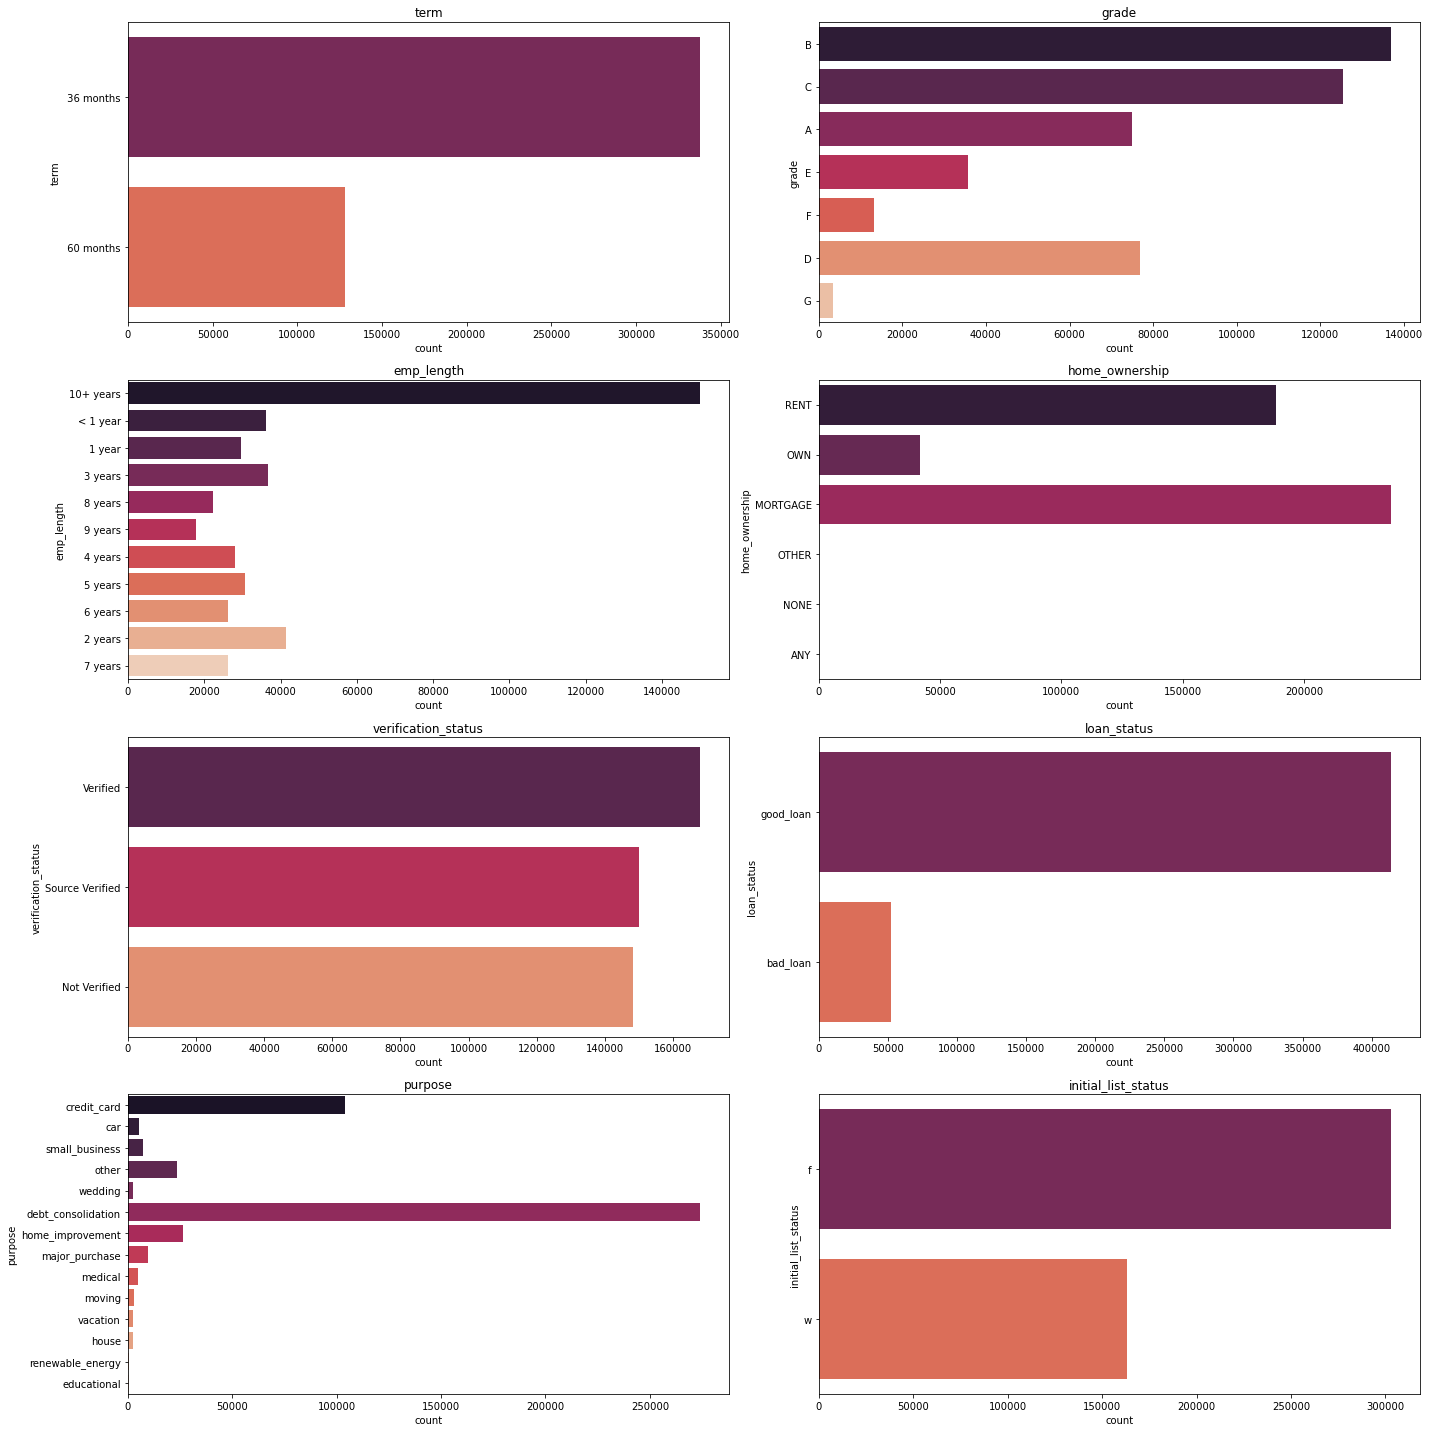

In [20]:
# Get categorical variables
cat_vars = df_1.select_dtypes(include='object').columns.tolist()

# Determine subplot layout
num_cols = len(cat_vars)
num_rows = (num_cols + 1) // 2

# Create subplot
fig, axs = plt.subplots(nrows = num_rows, ncols = 2, figsize = (20, 20))

# Plot count for each categorical variable
for i, var in enumerate(cat_vars):
    top_values = df_1[var]. value_counts().index
    filtered_df = df_1[df_1[var].isin(top_values)]
    
    # Plot count using seaborn
    sns.countplot(y = var, data = filtered_df, orient = 'h', ax = axs[i // 2, i % 2], palette = 'rocket')
    axs[i // 2, i % 2].set_title(var)
    
# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

Based on the graph above, we get some insights:

1. The `term` feature is dominated by 36 months. It menas the most borrowers opt for a loan term of 36 months, indicating a preference for shorter payment periods. This might be due to a desire to pay off the loan quickly and reduce overall interest payments. 
2. The `grade` feature is dominated by B. The high prevalence of grade B loans suggests that a significant portion of borrowers falls within this credit rating. Grade B loans typically represent a good credit score, indicating a relatively lower risk for lenders.
3. The `emp_length` feature is dominated by 10+ years. Borrowers with over 10 years of employment dominate the dataset. This may imply that individuals with longer employment histories are more likely to apply for loans, potentially reflecting increased financial stability and creditworthiness.
4. The `home_ownership` feature is dominated by MORTAGE. Most borrowers who register their home ownership status indicate having a mortgage. This information is crucial for lenders, as it provides insights into the financial stability of borrowers and their capacity to handle substantial financial commitments.
5. The `verification_status` feature is dominated by Verified. The prevalence of "Verified" status indicates that a significant number of borrowers have their co-borrowers' joint income verified by the lending platform. This verification process adds an extra layer of credibility to the income information provided by borrowers.
6. The `loan_status` as the target feature is dominated by good_loan. A substantial portion of loans in the dataset is classified as good loans. This implies that the majority of borrowers successfully meet their payment obligations, showcasing the overall health of the loan portfolio.
7. The `purpose` feature is dominated by debt_consolidation. Debt consolidation is the primary reason cited by borrowers for loan requests. This suggests that many borrowers are utilizing loans to consolidate their existing debts, potentially seeking better interest rates or more manageable repayment terms.
8. The `initial_list_status` is dominated by f. Loans predominantly have an initial listing status of "f," indicating that most loans are initially listed as fractional. This information is crucial for investors as it specifies the initial trading status of the loan on the lending platform. Fractional listing allows multiple investors to fund a single loan, spreading the risk across multiple lenders.

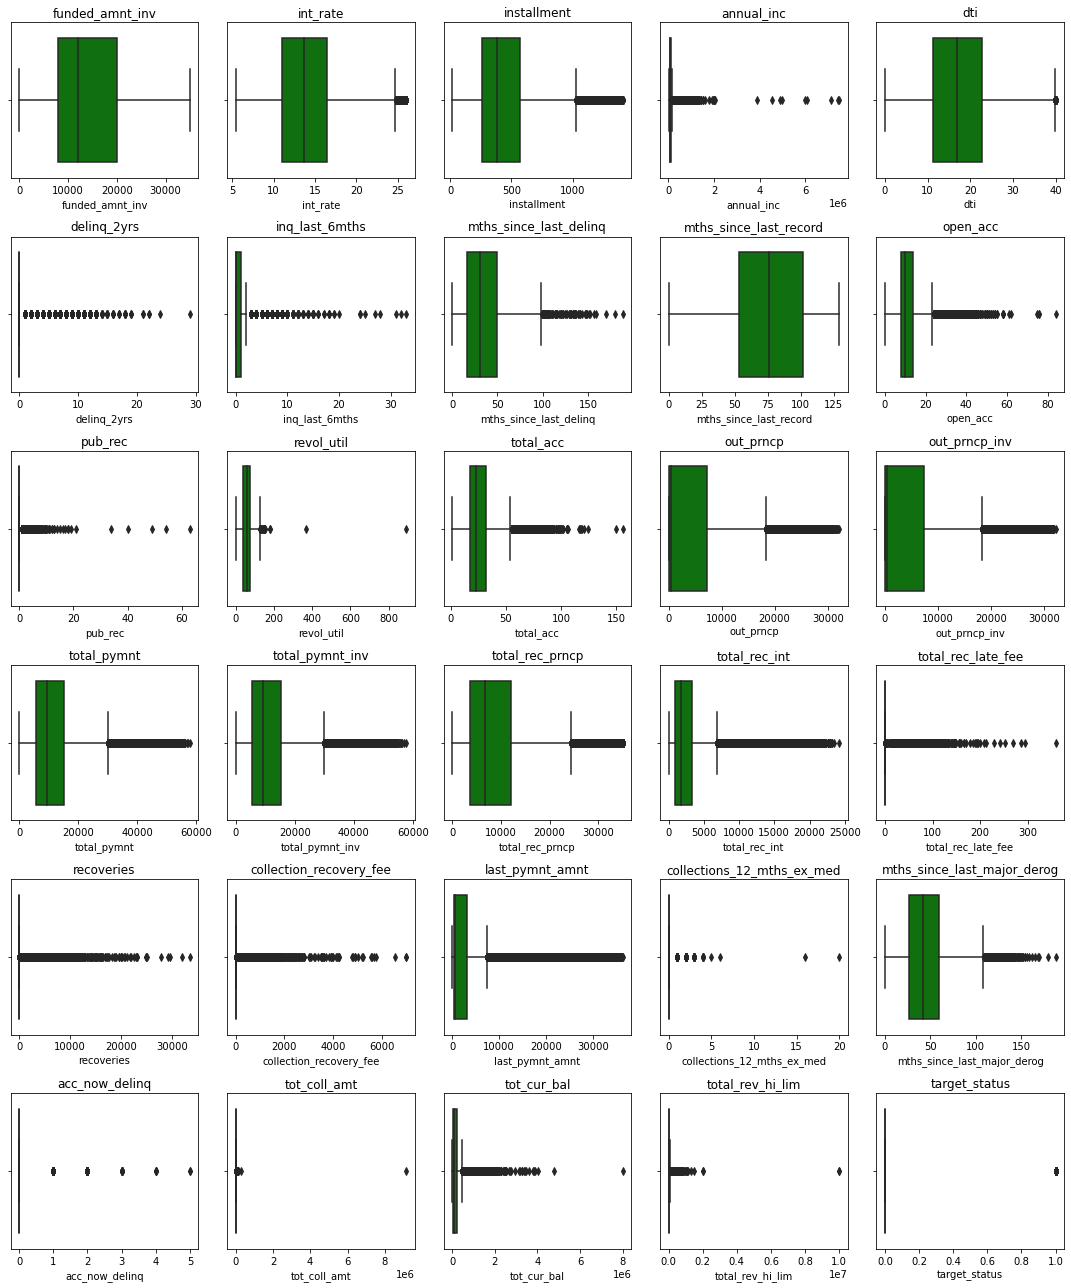

In [21]:
# Get all variables with data type numerical 'int' or 'float'
num_vars = df_1.select_dtypes(include=['int', 'float']).columns.tolist()

# Determine subplot layout
num_cols = len(num_vars)
num_rows = (num_cols + 4) // 5

# Create subplot
fig, axs = plt.subplots(nrows = num_rows, ncols = 5, figsize = (15, 3*num_rows))

# Plot boxplot for each numerical variables
for i, var in enumerate(num_vars):    
    sns.boxplot(x = df_1[var], ax = axs[i // 5, i % 5], color = 'g')
    axs[i // 5, i % 5].set_title(var)
    
# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])
    
# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

Based on the numerical data plotted above, several features exhibit outliers. However, to preserve valuable information where these outliers may represent specific and relevant situations in the context of loan approval, we have opted to retain the outliers. This decision is motivated by the understanding that outliers can capture unique scenarios that may be crucial for a comprehensive risk assessment in lending.

Furthermore, considering that this project leverages machine learning models such as Decision Trees and Random Forests, both of which inherently possess robustness in handling outliers, we are confident that the models can maintain their accuracy even in the presence of these exceptional data points. The decision to keep the outliers aligns with the recognition that these models are well-equipped to navigate variations in the data, ensuring a more nuanced and accurate representation of the credit risk landscape.

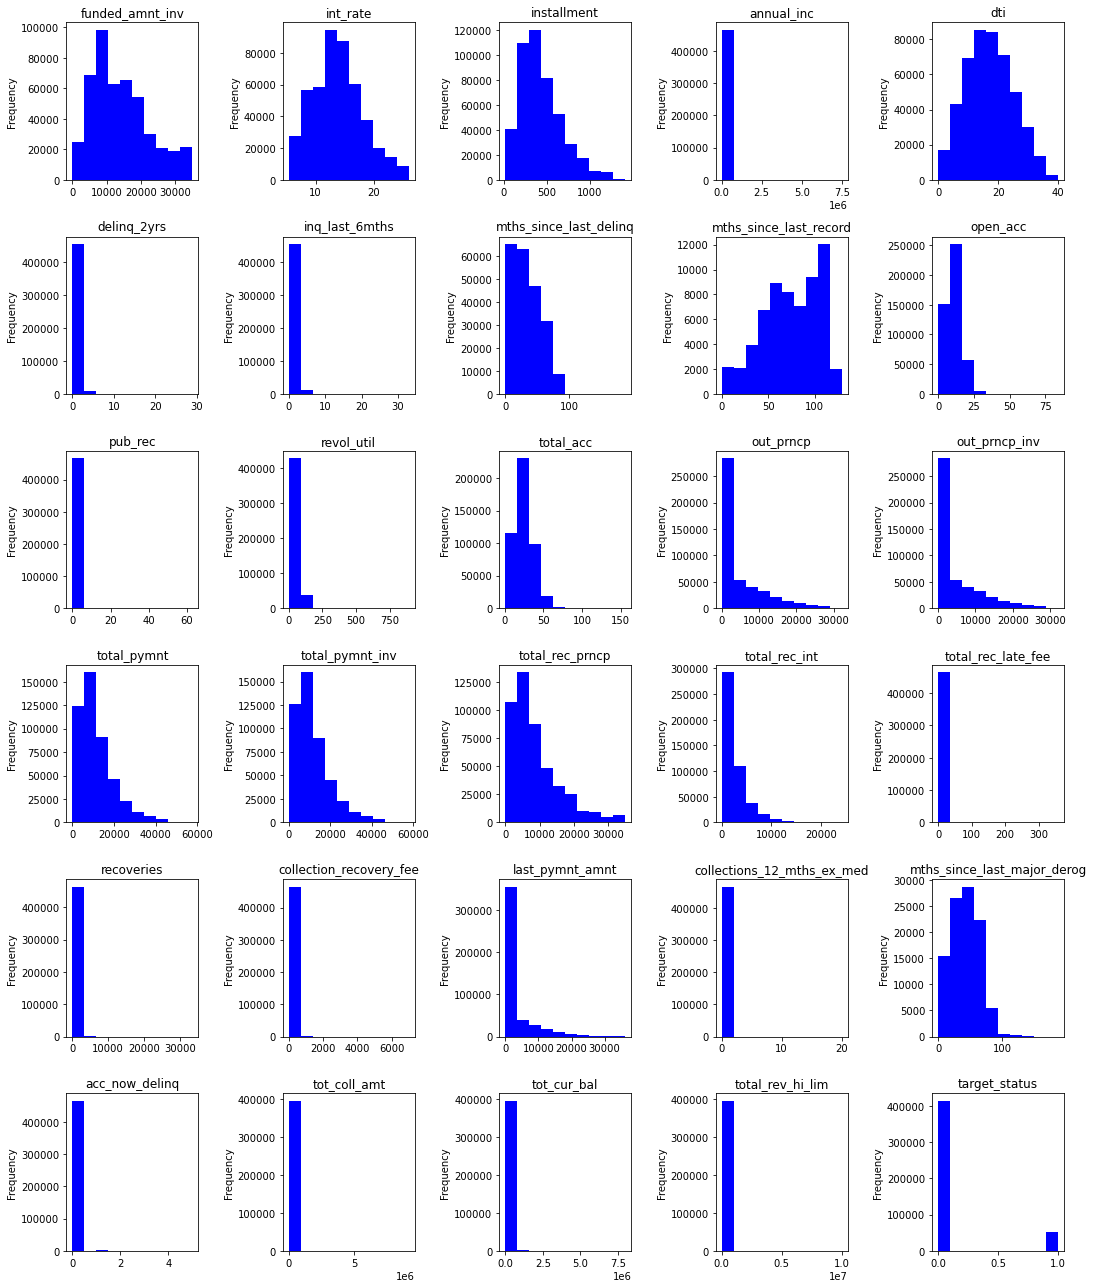

In [22]:
# Get all variables with data type numerical 'int' or 'float'
num_vars = df_1.select_dtypes(include=['int', 'float']).columns.tolist()

# Determine subplot layout
num_cols = len(num_vars)
num_rows = (num_cols + 4) // 5

# Create subplot
fig, axs = plt.subplots(nrows = num_rows, ncols = 5, figsize = (15, 3*num_rows))

# Plot boxplot for each numerical variables
for i, var in enumerate(num_vars):    
    df_1[var].plot.hist(ax = axs[i // 5, i % 5], color = 'b')
    axs[i // 5, i % 5].set_title(var)
    
# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])
    
# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

The histogram analysis reveals that many features exhibit a normal distribution, indicating a balanced spread of values. However, there are several features showcasing a right-skewed distribution. Understanding these distribution patterns provides valuable insights into determining appropriate strategies for handling missing values.

In cases where the data follows a normal distribution, filling missing values with the mean is a reasonable consideration. This approach leverages the central tendency of the data. On the other hand, for features exhibiting a right-skewed or left-skewed distribution, filling missing values with the median is a prudent alternative. The median, being less sensitive to extreme values, aligns well with the skewed nature of the data, offering a robust solution for handling missing values in such scenarios.

### Bivariate Analysis

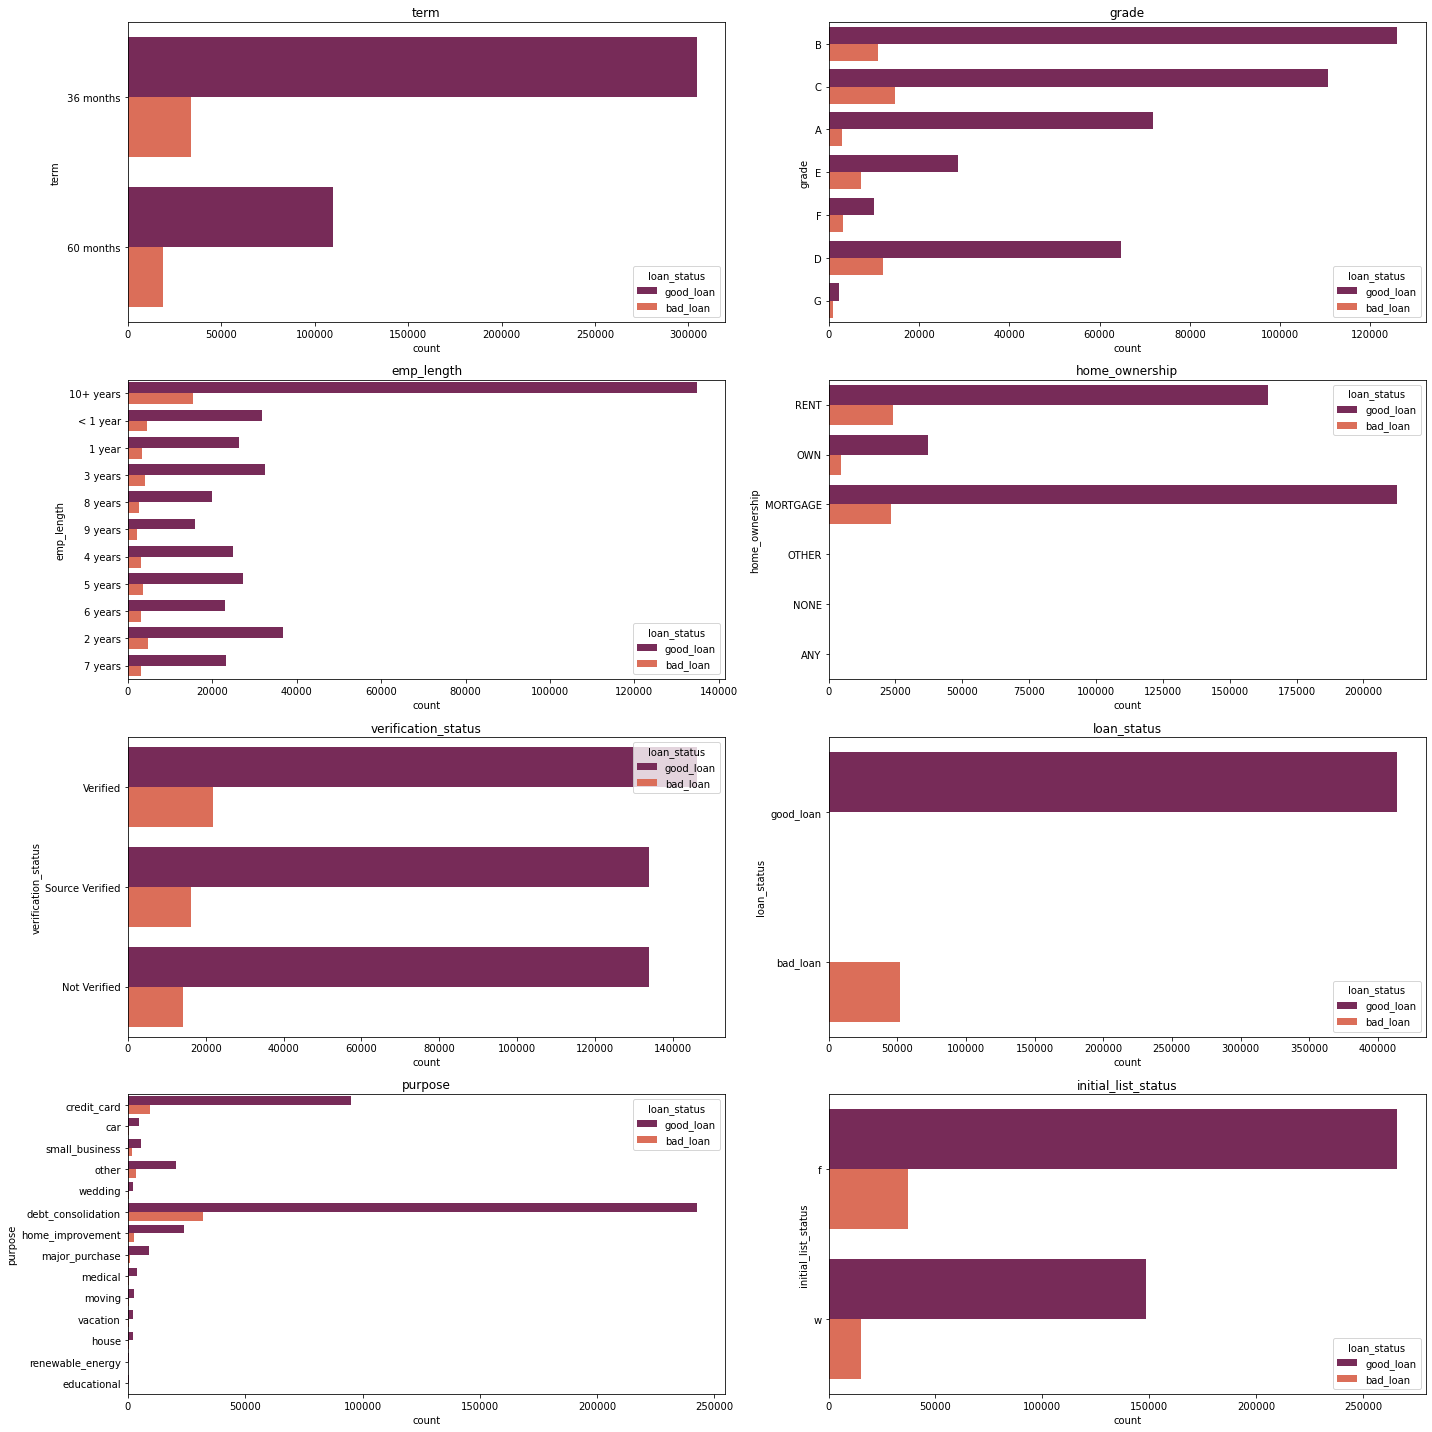

In [23]:
# Get categorical variables
cat_vars = df_1.select_dtypes(include='object').columns.tolist()

# Determine subplot layout
num_cols = len(cat_vars)
num_rows = (num_cols + 1) // 2

# Create subplot
fig, axs = plt.subplots(nrows = num_rows, ncols = 2, figsize = (20, 20))

# Plot count for each categorical variable
for i, var in enumerate(cat_vars):
    # Exclude rows with NaN values in the variable
    filtered_df = df_1[df_1[var].notnull()]
    
    # Plot count using seaborn
    sns.countplot(y = var, data = filtered_df, hue='loan_status', orient = 'h', ax = axs[i // 2, i % 2], palette = 'rocket')
    axs[i // 2, i % 2].set_title(var)

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()

## Feature Engineering for datetime dataypes

In [24]:
df_1[['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']].sample(3)

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
421199,2014-03-01,1996-01-01,2015-03-01,NaT,2016-01-01
203758,2012-08-01,2003-01-01,2014-06-01,NaT,2016-01-01
162637,2013-03-01,2006-04-01,2015-01-01,NaT,2015-06-01


In [25]:
from datetime import datetime

def month_diff(date1, date2):
    if not isinstance(date1, datetime) or not isinstance(date2, datetime):
        raise ValueError("Both inputs should be datetime objects.")
    
    months_difference = (date1.year - date2.year) * 12 + date1.month - date2.month
    return months_difference

def year_diff(date1, date2):
    if not isinstance(date1, datetime) or not isinstance(date2, datetime):
        raise ValueError("Both inputs should be datetime objects.")
    
    years_difference = date1.year - date2.year
    return years_difference

In [26]:
df_1['credit_age_at_loan_creation'] = df_1.apply(lambda row: month_diff(row['issue_d'], row['earliest_cr_line']), axis=1)
df_1['time_since_last_payment'] = df_1.apply(lambda row: month_diff(row['next_pymnt_d'], row['last_pymnt_d']), axis=1)
df_1['time_until_next_payment'] = df_1.apply(lambda row: month_diff(row['next_pymnt_d'], row['issue_d']), axis=1)
df_1['credit_pull_per_year'] = df_1.apply(lambda row: year_diff(row['last_credit_pull_d'], row['earliest_cr_line']), axis=1)

Based on information of datetime feature, it will be adding the new features:

1. `credit_age_at_loan_creation`: The credit age of prospective borrowers at the time of loan creation can provide insight into how long they have had a credit history. Lenders tend to view borrowers with a longer credit history as more reliable.
2. `time_since_last_payment`: Information about how long it has been since the last payment can provide an indication of the borrower's adherence to the payment schedule. Payment regularity is a crucial factor in assessing credit risk.
3. `time_until_next_payment`: Understanding how long it will be until the next payment provides insight into the time between payments and aids in portfolio liquidity planning.
4. `credit_pull_per_year`: The length of time between the opening of the first credit line and the last credit update can provide an overview of how frequently borrowers update or maintain their credit credibility.

In [27]:
df_1[df_1['credit_age_at_loan_creation']>0][['issue_d','earliest_cr_line','credit_age_at_loan_creation']].head(3)

,issue_d,earliest_cr_line,credit_age_at_loan_creation
0,2011-12-01,1985-01-01,323.0
1,2011-12-01,1999-04-01,152.0
2,2011-12-01,2001-11-01,121.0


In [28]:
df_1[df_1['time_since_last_payment']>2][['next_pymnt_d','last_pymnt_d','time_since_last_payment']].head(3)

,next_pymnt_d,last_pymnt_d,time_since_last_payment
318,2016-02-01,2015-08-01,6.0
749,2016-02-01,2015-09-01,5.0
1918,2016-02-01,2015-09-01,5.0


In [29]:
df_1[df_1['time_until_next_payment']>0][['next_pymnt_d','issue_d','time_until_next_payment']].head(3)

,next_pymnt_d,issue_d,time_until_next_payment
4,2016-02-01,2011-12-01,50.0
6,2016-02-01,2011-12-01,50.0
32,2016-01-01,2011-12-01,49.0


In [30]:
df_1[df_1['credit_pull_per_year']>0][['last_credit_pull_d','earliest_cr_line','credit_pull_per_year']].head(3)

,last_credit_pull_d,earliest_cr_line,credit_pull_per_year
0,2016-01-01,1985-01-01,31.0
1,2013-09-01,1999-04-01,14.0
2,2016-01-01,2001-11-01,15.0


In [31]:
df_1[df_1['credit_age_at_loan_creation'] < 0][['earliest_cr_line', 'credit_age_at_loan_creation', 'credit_pull_per_year']].head()

,earliest_cr_line,credit_age_at_loan_creation,credit_pull_per_year
1580,2062-09-01,-609.0,-49.0
1770,2068-09-01,-681.0,-53.0
2799,2064-09-01,-634.0,-48.0
3282,2067-09-01,-670.0,-52.0
3359,2065-02-01,-639.0,-51.0


The negative value in the `credit_age_at_loan_creation` and `credit_pull_per_year`, because it is a incorrect entry in the `earliest_cr_line`. Consequently, the entry with this value will be substituted with the maximum value.

In [32]:
max_credit_age = df_1['credit_age_at_loan_creation'].max()
max_credit_pull = df_1['credit_pull_per_year'].max()
df_1.loc[df_1['credit_age_at_loan_creation'] < 0, 'credit_age_at_loan_creation'] = max_credit_age
df_1.loc[df_1['credit_pull_per_year'] < 0, 'credit_pull_per_year'] = max_credit_pull

In [ ]:
# Drop column datetime type, because it is already extract

df_1.drop(columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'loan_status'], inplace = True)

In [35]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  purpose                      466285 non-null  object 
 12  dti                          466285 non-null  float64
 13 

In [136]:
# df_1.to_csv('loan_data_update.csv')

In [36]:
df_1.to_csv('loan_data_update_2.csv')

In [4]:
df_1 = pd.read_csv('loan_data_update_2.csv')
df_1.drop(columns = ['Unnamed: 0'], inplace = True)

## Data Preprocessing Part-2

### Handling Missing Value

In [37]:
# Calculate and display the percentage of missing values for each column
missing_percentages = (df_1.isnull().mean() * 100).sort_values(ascending = False)
missing_values = missing_percentages[missing_percentages > 0]
print(missing_values)

mths_since_last_record         86.566585
mths_since_last_major_derog    78.773926
mths_since_last_delinq         53.690554
time_since_last_payment        48.731141
time_until_next_payment        48.728567
total_rev_hi_lim               15.071469
tot_cur_bal                    15.071469
tot_coll_amt                   15.071469
emp_length                      4.505399
revol_util                      0.072917
collections_12_mths_ex_med      0.031097
credit_pull_per_year            0.015012
delinq_2yrs                     0.006219
inq_last_6mths                  0.006219
open_acc                        0.006219
pub_rec                         0.006219
total_acc                       0.006219
credit_age_at_loan_creation     0.006219
acc_now_delinq                  0.006219
annual_inc                      0.000858
dtype: float64


A common practice in data preprocessing involves discarding columns containing more than 50% missing values. This is because such columns typically do not provide sufficiently valuable information for analysis or model development. When a column exhibits a high percentage of missing values, it can introduce bias or noise that may impact the analysis or model-building process.

In [39]:
# Drop column that have more than 50% missing value
df_1.drop(columns = ['mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq'], inplace = True)

If `next_pymnt_d` is null, it is interpreted that there is no next scheduled payment, and therefore, there is no time difference between the last payment and the next payment. By replacing NaN with 0 on `time_since_last_payment`, it is indicating that the month difference is zero in this situation. On `time_until_next_payment`, it also indicates that there is no next scheduled payment after the issuance date.

In [40]:
df_1['time_since_last_payment'].fillna(0, inplace=True)
df_1['time_until_next_payment'].fillna(0, inplace=True)

In [41]:
columns = ['total_rev_hi_lim', 'tot_cur_bal', 'tot_coll_amt', 'revol_util', 'collections_12_mths_ex_med', 
           'credit_pull_per_year', 'inq_last_6mths', 'delinq_2yrs', 'open_acc', 'pub_rec', 'total_acc', 
           'credit_age_at_loan_creation', 'acc_now_delinq', 'annual_inc']
df_1[columns].describe()

,total_rev_hi_lim,tot_cur_bal,tot_coll_amt,revol_util,collections_12_mths_ex_med,credit_pull_per_year,inq_last_6mths,delinq_2yrs,open_acc,pub_rec,total_acc,credit_age_at_loan_creation,acc_now_delinq,annual_inc
count,3.960090e+05,3.960090e+05,3.960090e+05,465945.000000,466140.000000,466215.000000,466256.000000,466256.000000,466256.000000,466256.000000,466256.000000,466256.000000,466256.000000,4.662810e+05
mean,3.037909e+04,1.388017e+05,1.919135e+02,56.176947,0.009085,18.268020,0.804745,0.284678,11.187069,0.160564,25.064430,191.169182,0.004002,7.327738e+04
std,3.724713e+04,1.521147e+05,1.463021e+04,23.732628,0.108648,7.279424,1.091598,0.797365,4.987526,0.510863,11.600141,87.358781,0.068637,5.496357e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,1.896000e+03
25%,1.350000e+04,2.861800e+04,0.000000e+00,39.200000,0.000000,13.000000,0.000000,0.000000,8.000000,0.000000,17.000000,132.000000,0.000000,4.500000e+04
50%,2.280000e+04,8.153900e+04,0.000000e+00,57.600000,0.000000,17.000000,0.000000,0.000000,10.000000,0.000000,23.000000,174.000000,0.000000,6.300000e+04
75%,3.790000e+04,2.089530e+05,0.000000e+00,74.700000,0.000000,22.000000,1.000000,0.000000,14.000000,0.000000,32.000000,235.000000,0.000000,8.896000e+04
max,9.999999e+06,8.000078e+06,9.152545e+06,892.300000,20.000000,47.000000,33.000000,29.000000,84.000000,63.000000,156.000000,551.000000,5.000000,7.500000e+06


After analyzing numerical features, the decision has been made to handle missing values using the median to ensure a more stable representation of the data distribution.

In [43]:
df_1[columns] = df_1[columns].fillna(df_1[columns].median()) 

In [46]:
# Replace categorical columns 'emp_length' with Mode
df_1['emp_length'].fillna(df_1['emp_length'].mode()[0], inplace=True)

In [47]:
df_1.isna().sum()

loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
term                           0
int_rate                       0
installment                    0
grade                          0
emp_length                     0
home_ownership                 0
annual_inc                     0
verification_status            0
purpose                        0
dti                            0
delinq_2yrs                    0
inq_last_6mths                 0
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                     0
total_acc                      0
initial_list_status            0
out_prncp                      0
out_prncp_inv                  0
total_pymnt                    0
total_pymnt_inv                0
total_rec_prncp                0
total_rec_int                  0
total_rec_late_fee             0
recoveries                     0
collection_recovery_fee        0
last_pymnt

## Feature Selection

### Correlation Matrix with Heatmap

<AxesSubplot:>

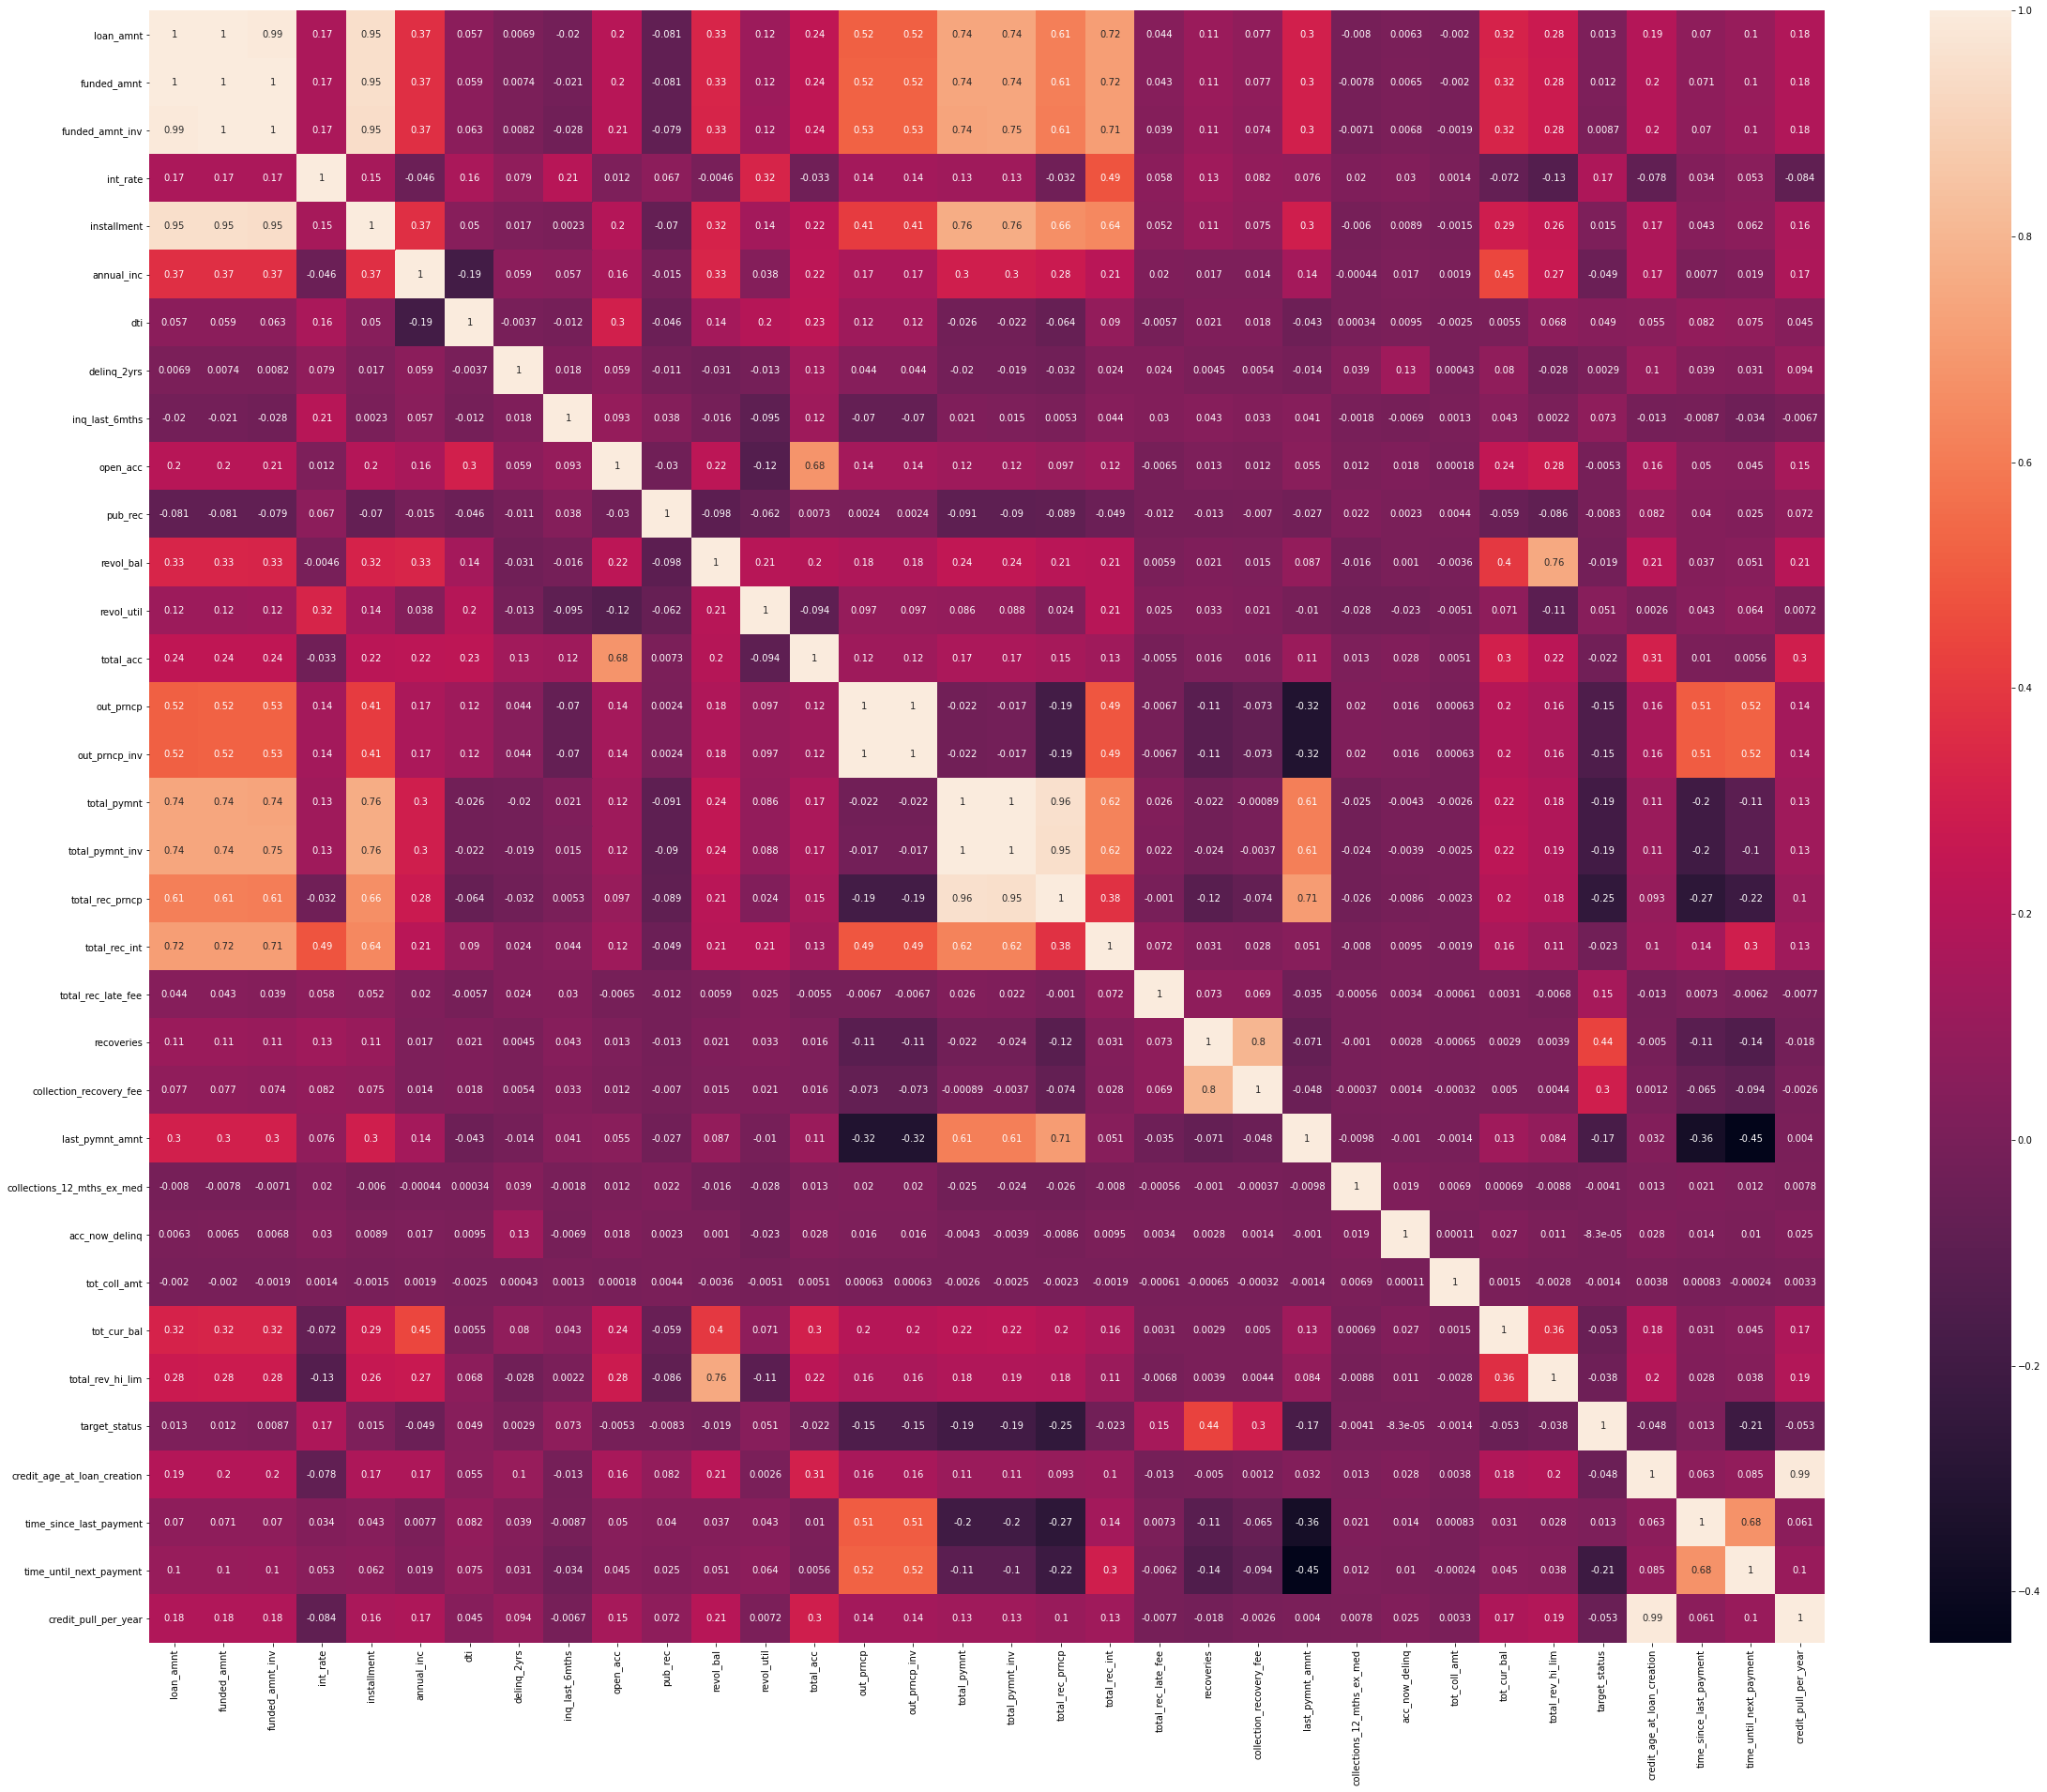

In [50]:
plt.figure(figsize=(40, 32))
sns.heatmap(df_1.corr(), fmt='.2g', annot=True)

Based on correlation matrix, the presence of numerous independent features exhibiting a high correlation with one another. This situation poses a risk of introducing bias into the results if not addressed appropriately.

Consequently, a decision has been made to eliminate features demonstrating a correlation exceeding 0.7. This strategic move aims to mitigate the potential impact of multicollinearity, ensuring a more robust and reliable analysis by focusing on less interdependent features.

In [51]:
# Correlation matrix
correlation_matrix = df_1.corr().abs()

# Filter elements above the main diagonal
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool)
upper_corr_matrix = correlation_matrix.where(upper_triangle)

# Find columns with high correlation
highly_correlated_columns = [col for col in upper_corr_matrix.columns if any(upper_corr_matrix[col] > 0.7)]
highly_correlated_columns

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'total_rev_hi_lim',
 'credit_pull_per_year']

In [52]:
df_1.drop(highly_correlated_columns, axis = 1, inplace = True)

<AxesSubplot:>

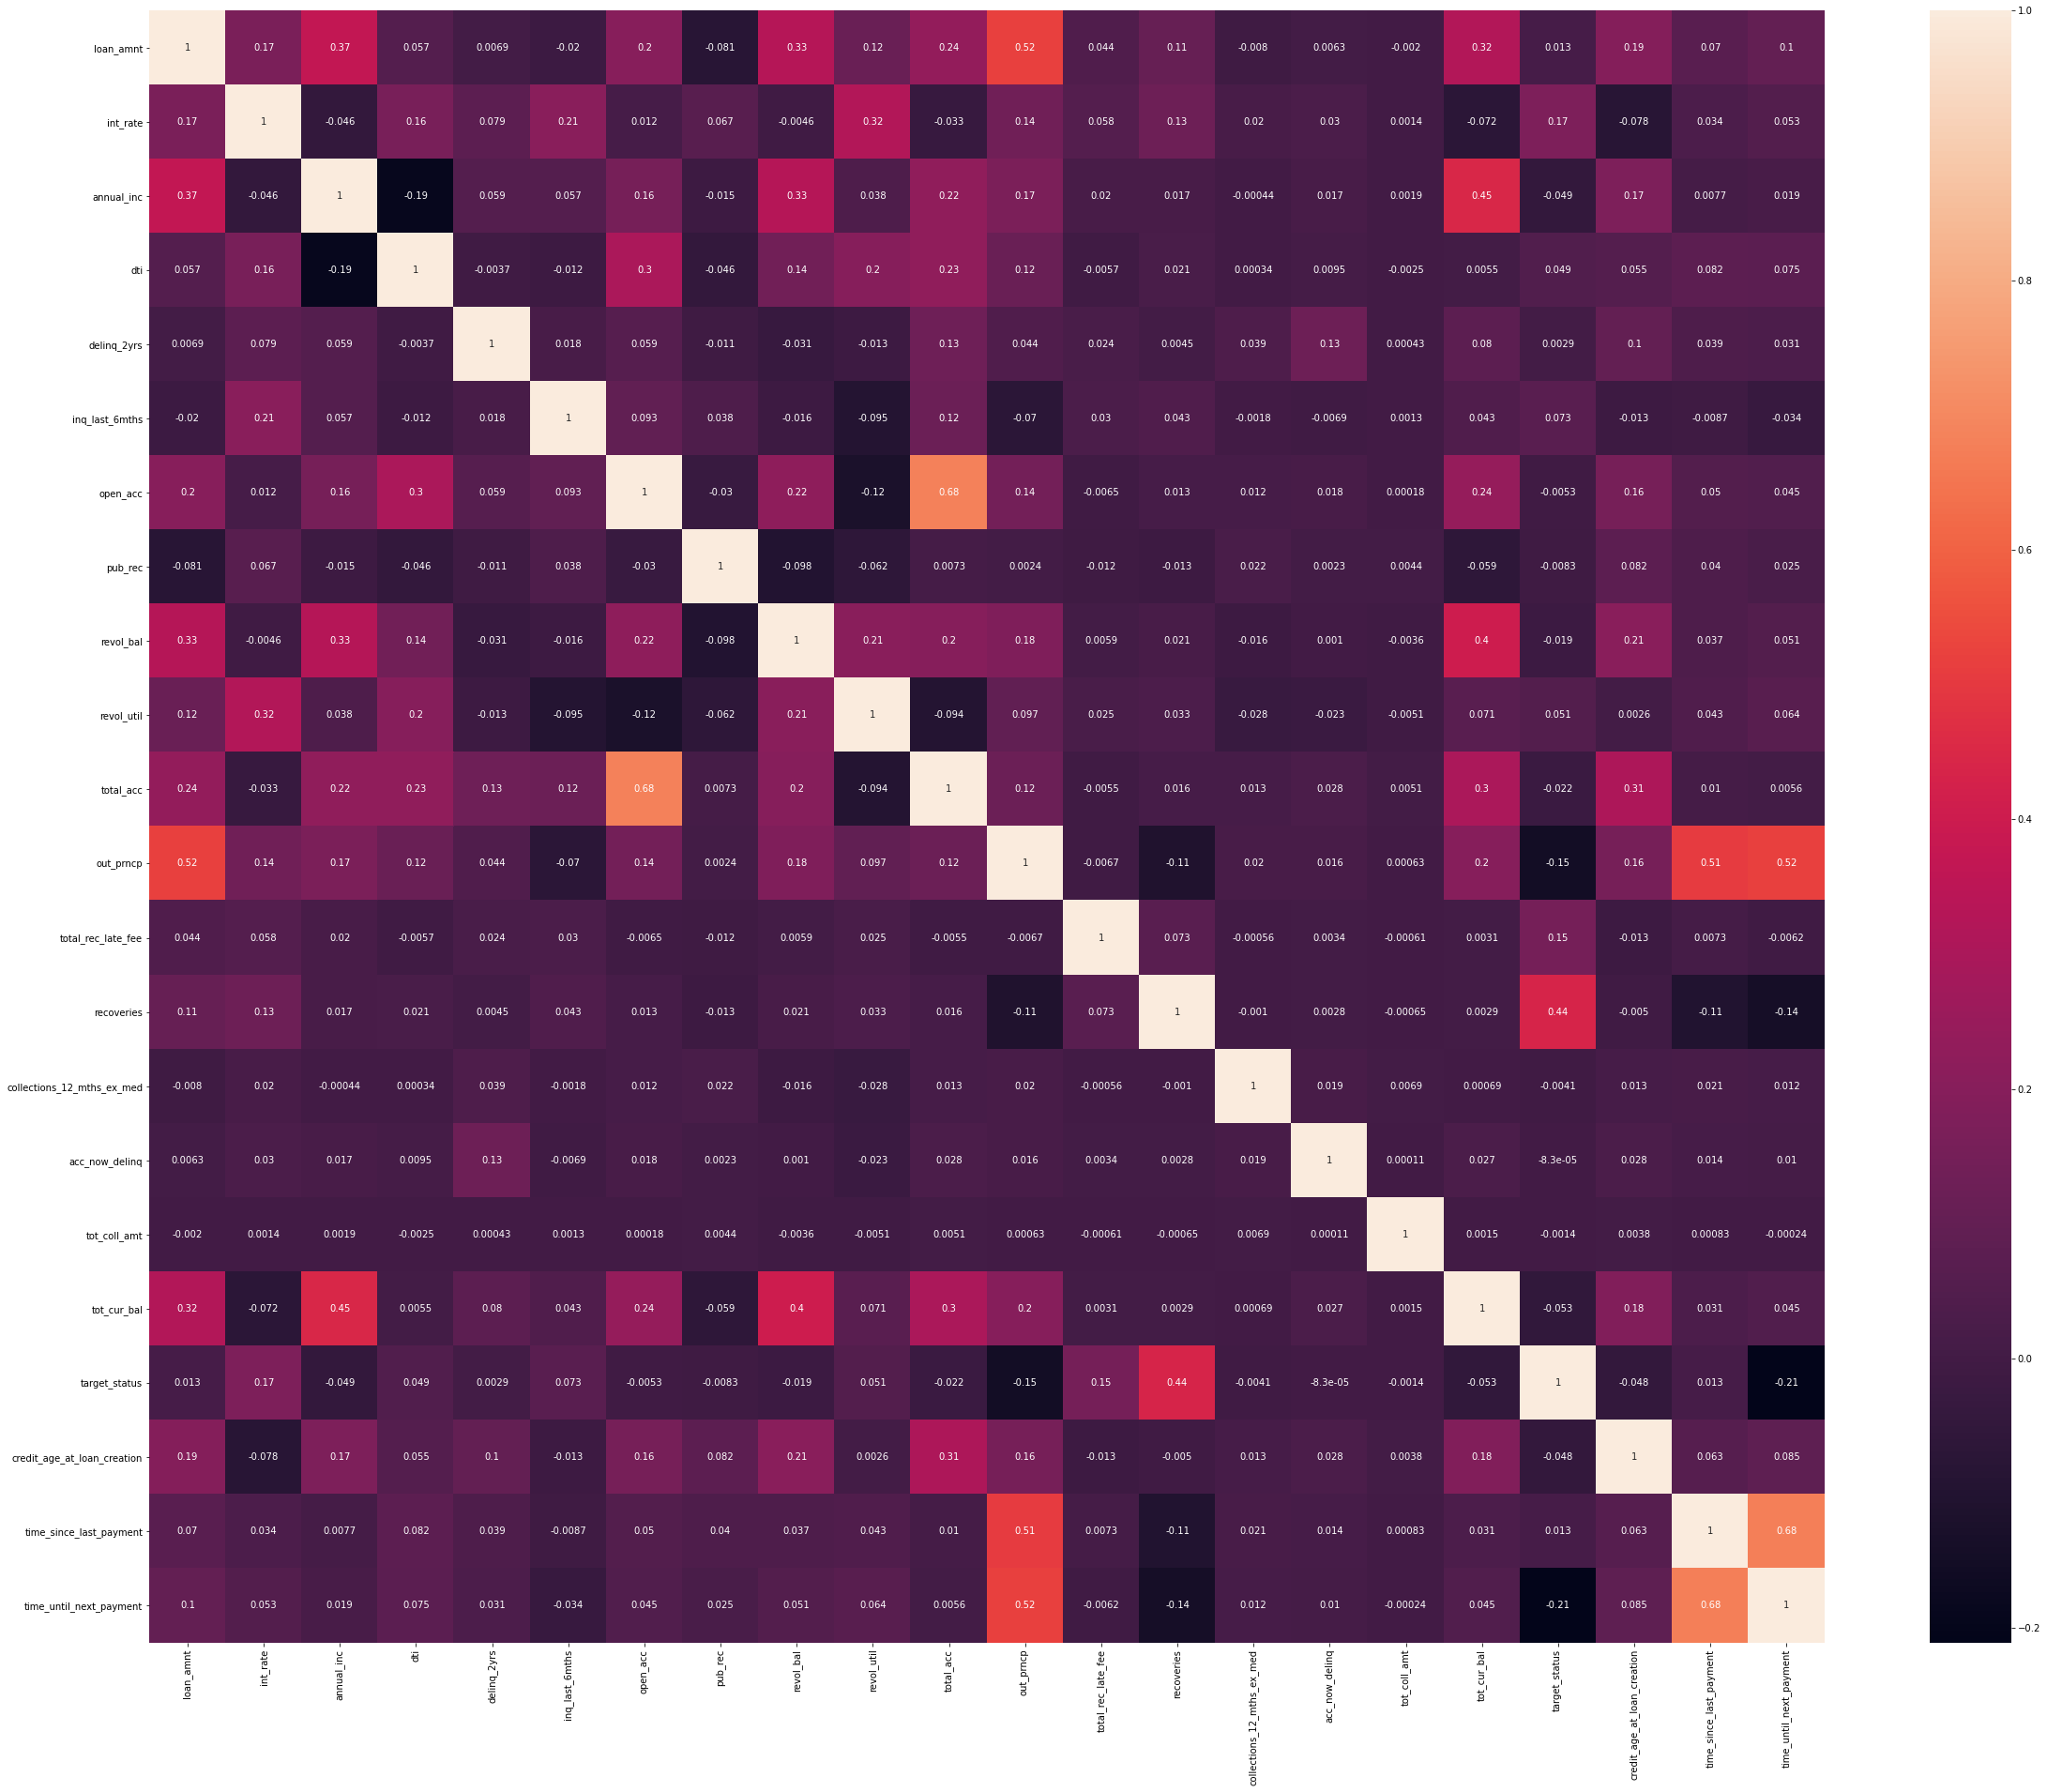

In [54]:
plt.figure(figsize=(40, 32))
sns.heatmap(df_1.corr(), fmt='.2g', annot=True)

In [53]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   term                         466285 non-null  object 
 2   int_rate                     466285 non-null  float64
 3   grade                        466285 non-null  object 
 4   emp_length                   466285 non-null  object 
 5   home_ownership               466285 non-null  object 
 6   annual_inc                   466285 non-null  float64
 7   verification_status          466285 non-null  object 
 8   purpose                      466285 non-null  object 
 9   dti                          466285 non-null  float64
 10  delinq_2yrs                  466285 non-null  float64
 11  inq_last_6mths               466285 non-null  float64
 12  open_acc                     466285 non-null  float64
 13 

In [56]:
# df_1.to_csv('loan_data_after_cleaning.csv')

## Feature Encoding

### Label encoding for object datatypes

In [4]:
for col in df_1.select_dtypes(include='object').columns:
    unique_values = df_1[col].unique()
    print(f"{col}: {unique_values}")

term: [' 36 months' ' 60 months']
grade: ['B' 'C' 'A' 'E' 'F' 'D' 'G']
emp_length: ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years']
home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
verification_status: ['Verified' 'Source Verified' 'Not Verified']
purpose: ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
initial_list_status: ['f' 'w']


In [5]:
# Replacing values with more segmented
replacement_dict = {'MORTGAGE': 'MORTGAGE',
                    'RENT': 'RENT',
                    'OWN': 'OWN',
                    'OTHER': 'OTHER',
                    'ANY': 'OTHER',
                    'NONE': 'OTHER'}

df_1['home_ownership'] = df_1['home_ownership'].replace(replacement_dict)
df_1['home_ownership'].value_counts()

MORTGAGE    235875
RENT        188473
OWN          41704
OTHER          233
Name: home_ownership, dtype: int64

In [6]:
# label encoding for 'term' into numerical
df_1['term'] = np.where(df_1['term']==' 36 months', 0, 1)

In [10]:
df_1['initial_list_status'] = np.where(df_1['initial_list_status']=='f', 0, 1)

### One-Hot Encoding 

In [13]:
categorical_columns = ['grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']

# onehotencoding for categorical columns
for col in [categorical_columns]:
    df_encoded = pd.get_dummies(df_1[col], prefix = col, drop_first=True)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   grade_B                              466285 non-null  uint8
 1   grade_C                              466285 non-null  uint8
 2   grade_D                              466285 non-null  uint8
 3   grade_E                              466285 non-null  uint8
 4   grade_F                              466285 non-null  uint8
 5   grade_G                              466285 non-null  uint8
 6   emp_length_10+ years                 466285 non-null  uint8
 7   emp_length_2 years                   466285 non-null  uint8
 8   emp_length_3 years                   466285 non-null  uint8
 9   emp_length_4 years                   466285 non-null  uint8
 10  emp_length_5 years                   466285 non-null  uint8
 11  emp_length_6 years                   46

In [14]:
# Drop the original categorical columns once the corresponding encoding columns have been generated
df_1 = df_1.drop(categorical_columns, axis = 1)

# Concanate the df_1 and df_encoded
df_modeling = pd.concat([df_1, df_encoded], axis = 1)

df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 58 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            466285 non-null  int64  
 1   term                                 466285 non-null  int32  
 2   int_rate                             466285 non-null  float64
 3   annual_inc                           466285 non-null  float64
 4   dti                                  466285 non-null  float64
 5   delinq_2yrs                          466285 non-null  float64
 6   inq_last_6mths                       466285 non-null  float64
 7   open_acc                             466285 non-null  float64
 8   pub_rec                              466285 non-null  float64
 9   revol_bal                            466285 non-null  int64  
 10  revol_util                           466285 non-null  float64
 11  total_acc    

In [16]:
# df_modeling.to_csv('loan_data_final_modeling.csv')

## Train & Test Split

In [4]:
# Splitting the dataset
x = df_modeling.drop(['target_status'], axis = 1)
y = df_modeling['target_status']

In [5]:
# Convert to numpy arrays
x = x.values
y = y.values

In [6]:
# Shuffle the data to ensure the overall distribution of the data
# before split into train dan test data
z = list(zip(x, y))
random.shuffle(z)
x, y = zip(*z)
x, y = np.array(x), np.array(y)

In [7]:
# Split the data into training and testing sets
# Training 70% : Testing 30%

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [8]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((326399, 57), (139886, 57), (326399,), (139886,))

## Imbalanced Data Solutions: SMOTE

In [9]:
# Display class distribution before SMOTE
print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))
print("Before OverSampling, counts of label '1': {} \n".format(sum(y_train == 1)))

# Apply SMOTE to balance the class distribution
sm = SMOTE()
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train.ravel())

# Display class distribution after SMOTE
print('After OverSampling, the shape of x_train: {}'.format(x_train_smote.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote == 0)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote == 1)))

Before OverSampling, counts of label '0': 289808
Before OverSampling, counts of label '1': 36591 

After OverSampling, the shape of x_train: (579616, 57)
After OverSampling, the shape of y_train: (579616,) 

After OverSampling, counts of label '1': 289808
After OverSampling, counts of label '0': 289808


## Predictive Modeling

In [10]:
# Evaluate model function 
def evaluate_model(model, x_test, y_test, x_smote, y_smote):
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_smote)
    y_pred_proba = model.predict_proba(x_test)
    y_pred_proba_train = model.predict_proba(x_smote)
    
    print(f'Classification Report {model}:\n{classification_report(y_test, y_pred)}')
    print(f'AUC Score Train Proba: {round(roc_auc_score(y_smote, y_pred_proba_train[:,1]), 6)}')
    print(f'AUC Score Test proba: {round(roc_auc_score(y_test, y_pred_proba[:,1]), 6)}\n')
    
# Confusion matrix function
def plot_confusion_matrix(y_test, y_pred, classes, normalize = False, title = None, cmap=plt.cm.Blues, figsize=(5, 5)):
    
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def plot_roc_curve(model, x_test, y_test):
    
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'AUC = {round(auc, 3)}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('ROC Curve', fontsize=15)
    plt.legend()
    plt.show()
    
def plot_top_features_importance(model, df_modeling, target_column, top_n=10, figsize=(10, 8)):

    feature_names = df_modeling.columns[df_modeling.columns != target_column]
    
    # Assuming model has feature_importances_ attribute
    if hasattr(model, 'feature_importances_'):
        feature_df = pd.DataFrame({
            'Feature Name': feature_names,
            'Importance': model.feature_importances_
        })

        # Sorting features based on importance and selecting the top N
        top_features = feature_df.nlargest(top_n, 'Importance')

        # Plotting a bar plot for the top N feature importance
        plt.figure(figsize=figsize)
        sns.barplot(data=top_features, x='Importance', y='Feature Name', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance Obtained by Each Attribute', fontsize=16)
        plt.xlabel('Importance', fontsize=16)
        plt.ylabel('Feature Name', fontsize=16)
        plt.show()
    else:
        print("Model doesn't have feature_importances_ attribute.")

### Decision Tree Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier

# Default model DecisionTreeClassifier
DecisionTreeClassifier = DecisionTreeClassifier()
DecisionTreeClassifier.fit(x_train_smote, y_train_smote)

DecisionTreeClassifier()

In [13]:
evaluate_model(DecisionTreeClassifier, x_test, y_test, x_train_smote, y_train_smote)

Classification Report DecisionTreeClassifier():
              precision    recall  f1-score   support

           0       0.96      0.95      0.95    124140
           1       0.62      0.67      0.64     15746

    accuracy                           0.92    139886
   macro avg       0.79      0.81      0.80    139886
weighted avg       0.92      0.92      0.92    139886

AUC Score Train Proba: 1.0
AUC Score Test proba: 0.807128



Confusion matrix, without normalization
[[117668   6472]
 [  5253  10493]]


<AxesSubplot:title={'center':'Confusion Matrix Decision Tree'}, xlabel='Predicted label', ylabel='Actual label'>

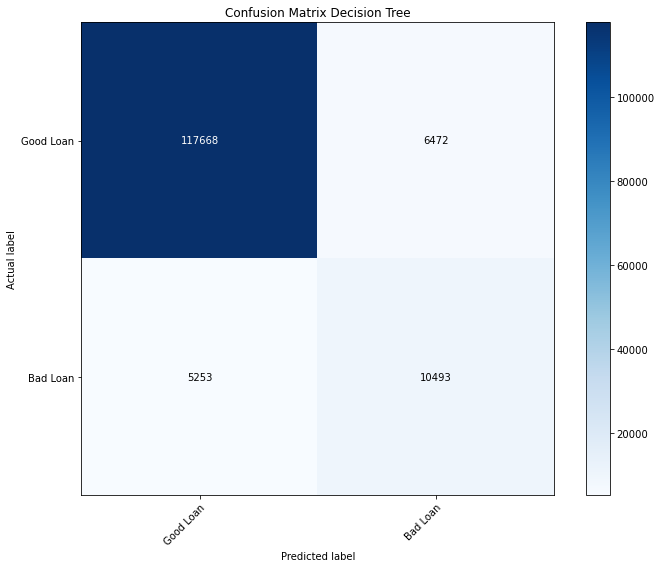

In [14]:
target = ['Good Loan', 'Bad Loan']
y_pred = DecisionTreeClassifier.predict(x_test)

plot_confusion_matrix(y_test, y_pred, target, title = 'Confusion Matrix Decision Tree', figsize=(10,8))

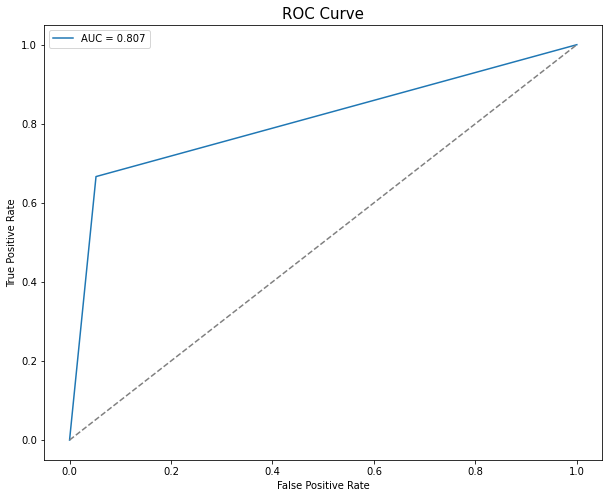

In [15]:
y_pred_proba = DecisionTreeClassifier.predict_proba(x_test)[:][:,1]

fpr, tpr, tr = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='AUC = %0.3f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='grey')
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('ROC Curve', fontsize=15)
plt.legend()

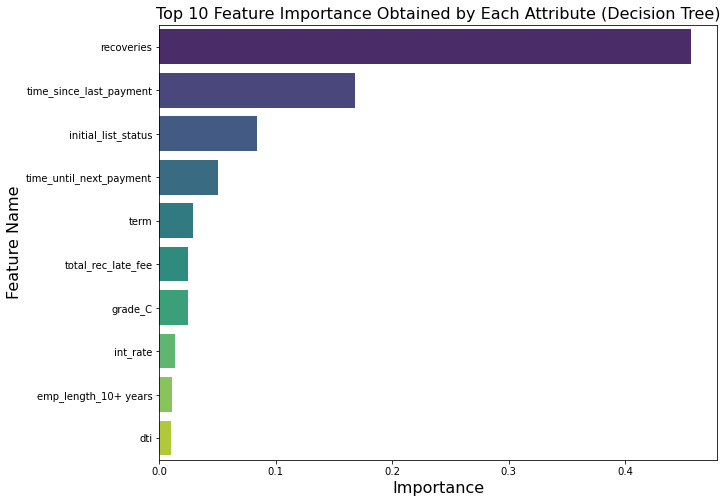

In [16]:
feature_names = df_modeling.columns[df_modeling.columns != 'target_status']
feature_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': DecisionTreeClassifier.feature_importances_
})

# Sorting features based on importance and selecting the top 10
top_10_features = feature_df.nlargest(10, 'Importance')

# Plotting a bar plot for the top 10 feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=top_10_features, x='Importance', y='Feature Name', palette='viridis')
plt.title('Top 10 Feature Importance Obtained by Each Attribute (Decision Tree)', fontsize=16)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature Name', fontsize=16)
plt.show()

In [ ]:
x_test_df = pd.DataFrame(x_test, columns=feature_names)

# Creating a TreeExplainer for the Decision Tree model
explainer = shap.TreeExplainer(DecisionTreeClassifier)

# Generating SHAP values for x_test
shap_values = explainer.shap_values(x_test)

mean_shap_values = abs(shap_values).mean(axis=0)

# Sorting features based on average SHAP values and selecting the top 10
top_10_features = pd.DataFrame({
    'Feature Name': feature_names,
    'Mean SHAP Value': mean_shap_values
}).nlargest(10, 'Mean SHAP Value')

# Plotting a summary plot for top 10 features based on SHAP values
shap.summary_plot(shap_values[2], x_test_df, feature_names=feature_names, plot_type='bar', order=top_10_features['Feature Name'])
plt.show()

### Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Default model RandomForestClassifier
RandomForestClassifier = RandomForestClassifier()
RandomForestClassifier.fit(x_train_smote, y_train_smote)

RandomForestClassifier()

In [18]:
evaluate_model(RandomForestClassifier, x_test, y_test, x_train_smote, y_train_smote)

Classification Report RandomForestClassifier():
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    124140
           1       0.99      0.60      0.75     15746

    accuracy                           0.95    139886
   macro avg       0.97      0.80      0.86    139886
weighted avg       0.96      0.95      0.95    139886

AUC Score Train Proba: 1.0
AUC Score Test proba: 0.926298



Confusion matrix, without normalization
[[124039    101]
 [  6282   9464]]


<AxesSubplot:title={'center':'Confusion Matrix Random Forest'}, xlabel='Predicted label', ylabel='Actual label'>

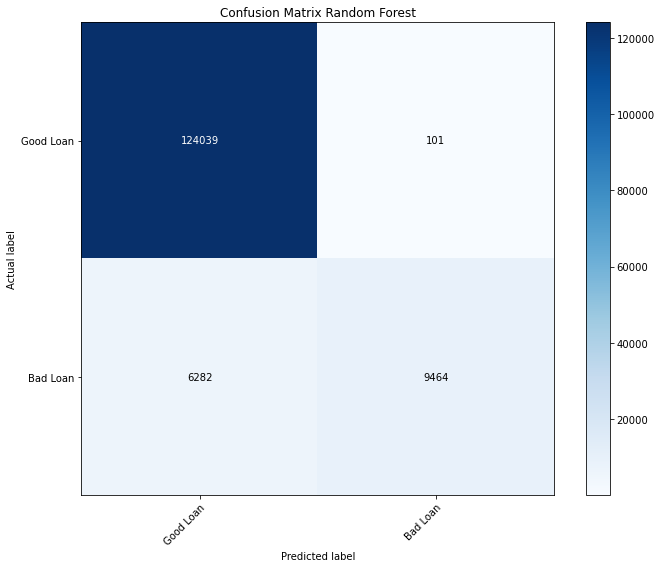

In [19]:
target = ['Good Loan', 'Bad Loan']
y_pred = RandomForestClassifier.predict(x_test)

plot_confusion_matrix(y_test, y_pred, target, title = 'Confusion Matrix Random Forest', figsize=(10,8))

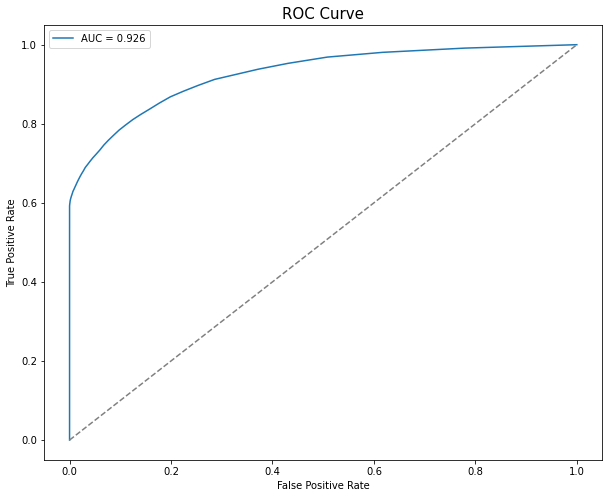

In [22]:
plot_roc_curve(RandomForestClassifier, x_test, y_test)

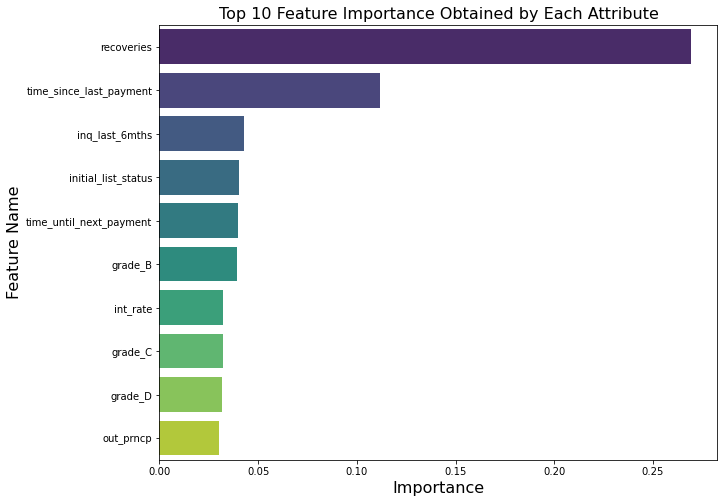

In [23]:
plot_top_features_importance(RandomForestClassifier, df_modeling, 'target_status')

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

# Default model LogisticRegression
LogisticRegression = LogisticRegression()
LogisticRegression.fit(x_train_smote, y_train_smote)

LogisticRegression()

In [25]:
evaluate_model(LogisticRegression, x_test, y_test, x_train_smote, y_train_smote)

Classification Report LogisticRegression():
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    124140
           1       0.86      0.49      0.62     15746

    accuracy                           0.93    139886
   macro avg       0.90      0.74      0.79    139886
weighted avg       0.93      0.93      0.93    139886

AUC Score Train Proba: 0.851956
AUC Score Test proba: 0.793357



Confusion matrix, without normalization
[[122890   1250]
 [  8056   7690]]


<AxesSubplot:title={'center':'Confusion Matrix Random Forest'}, xlabel='Predicted label', ylabel='Actual label'>

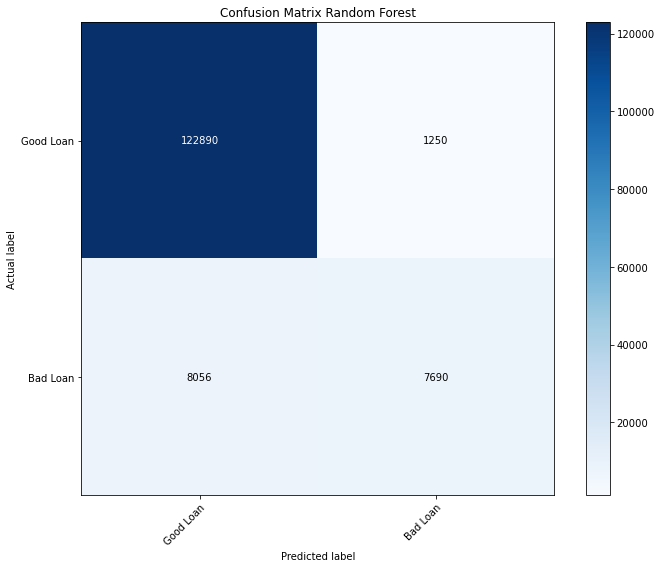

In [26]:
target = ['Good Loan', 'Bad Loan']
y_pred = LogisticRegression.predict(x_test)

plot_confusion_matrix(y_test, y_pred, target, title = 'Confusion Matrix Random Forest', figsize=(10,8))

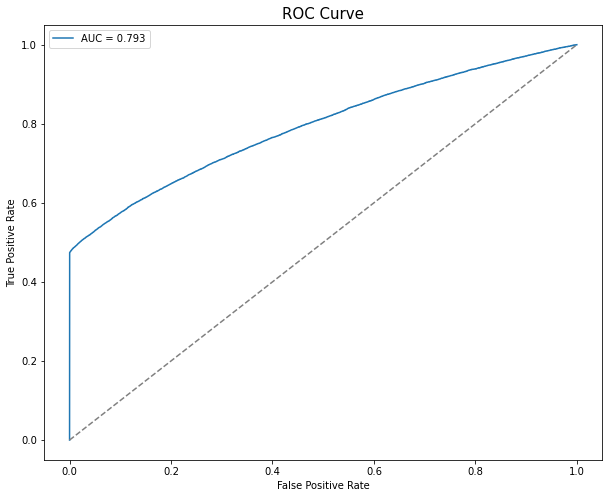

In [27]:
plot_roc_curve(LogisticRegression, x_test, y_test)

In [28]:
plot_top_features_importance(LogisticRegression, df_modeling, 'target_status')

Model doesn't have feature_importances_ attribute.


### XGBoost Classifier

In [29]:
from xgboost import XGBClassifier

# Default model XGBClassifier
XGBClassifier = XGBClassifier()
XGBClassifier.fit(x_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
evaluate_model(XGBClassifier, x_test, y_test, x_train_smote, y_train_smote)

Classification Report XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    124140
           1       0.97      0.61      0.75     15746

    accuracy                           0.95    139886
 

Confusion matrix, without normalization
[[123893    247]
 [  6141   9605]]


<AxesSubplot:title={'center':'Confusion Matrix XGBoost'}, xlabel='Predicted label', ylabel='Actual label'>

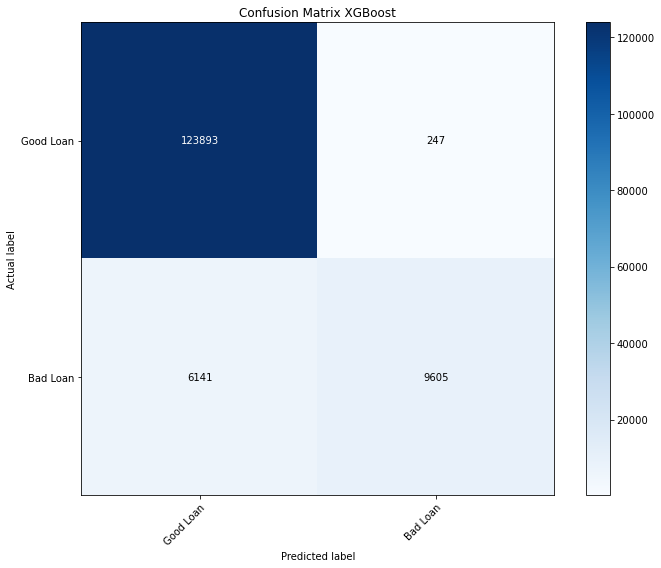

In [37]:
target = ['Good Loan', 'Bad Loan']
y_pred = XGBClassifier.predict(x_test)

plot_confusion_matrix(y_test, y_pred, target, title = 'Confusion Matrix XGBoost', figsize=(10,8))

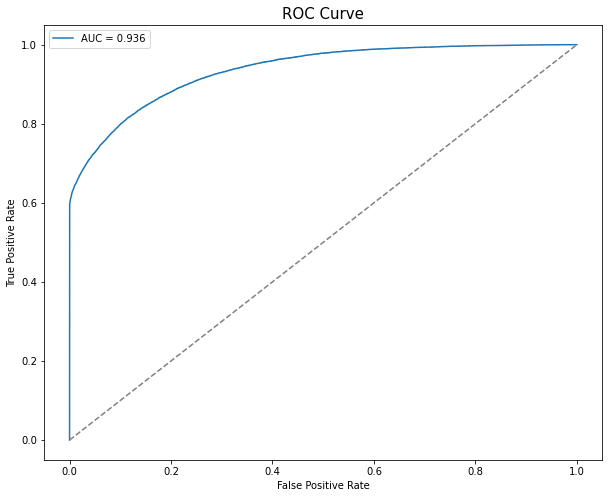

In [32]:
plot_roc_curve(XGBClassifier, x_test, y_test)

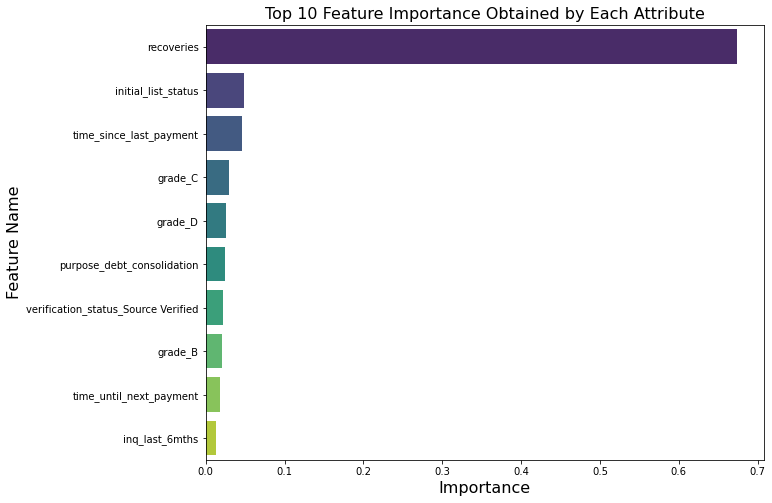

In [33]:
plot_top_features_importance(XGBClassifier, df_modeling, 'target_status')

### AdaBoost Classifier

In [34]:
from sklearn.ensemble import AdaBoostClassifier

# Default model AdaBoostClassifier
AdaBoostClassifier = AdaBoostClassifier()
AdaBoostClassifier.fit(x_train_smote, y_train_smote)

AdaBoostClassifier()

In [38]:
evaluate_model(AdaBoostClassifier, x_test, y_test, x_train_smote, y_train_smote)

Classification Report AdaBoostClassifier():
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    124140
           1       0.94      0.62      0.75     15746

    accuracy                           0.95    139886
   macro avg       0.94      0.81      0.86    139886
weighted avg       0.95      0.95      0.95    139886

AUC Score Train Proba: 0.989737
AUC Score Test proba: 0.924275



Confusion matrix, without normalization
[[123471    669]
 [  5984   9762]]


<AxesSubplot:title={'center':'Confusion Matrix AdaBoost'}, xlabel='Predicted label', ylabel='Actual label'>

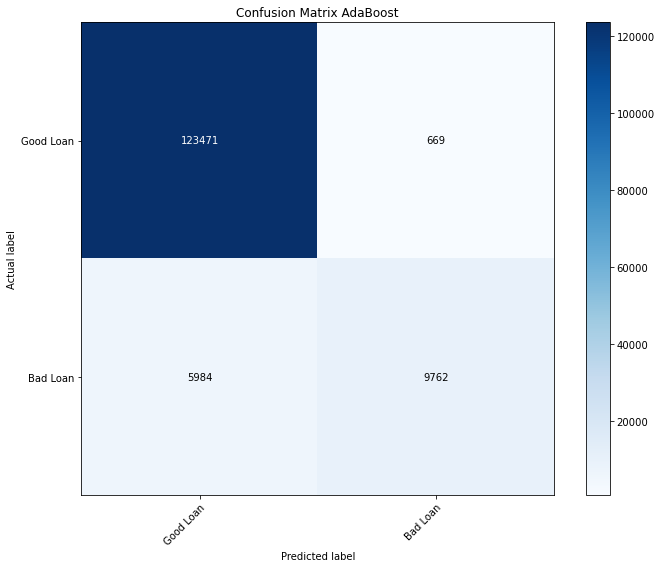

In [36]:
target = ['Good Loan', 'Bad Loan']
y_pred = AdaBoostClassifier.predict(x_test)

plot_confusion_matrix(y_test, y_pred, target, title = 'Confusion Matrix AdaBoost', figsize=(10,8))

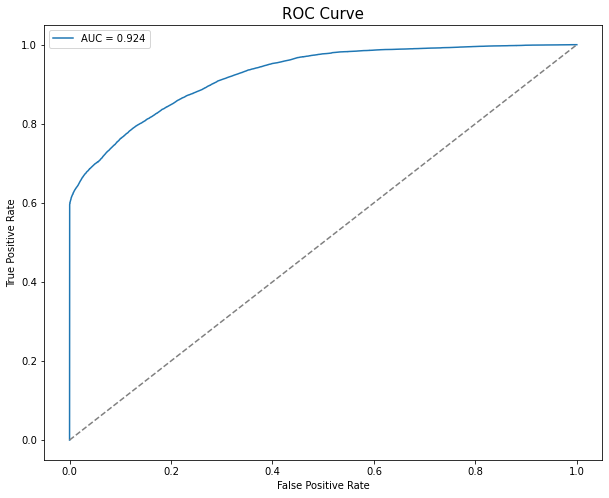

In [39]:
plot_roc_curve(AdaBoostClassifier, x_test, y_test)

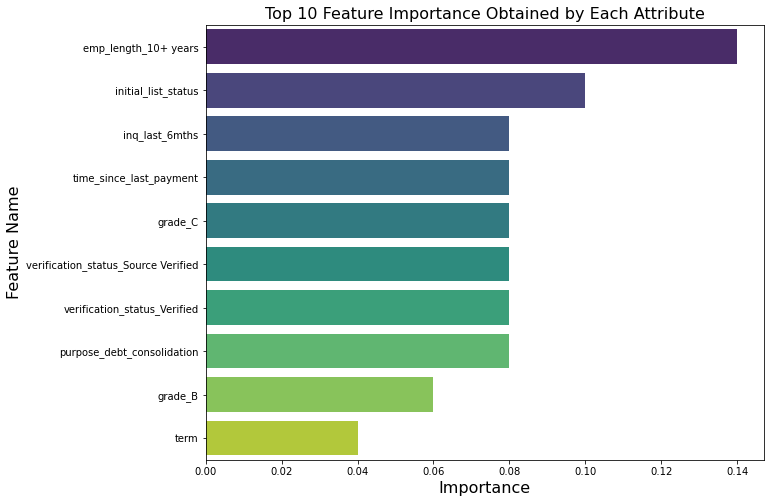

In [40]:
plot_top_features_importance(AdaBoostClassifier, df_modeling, 'target_status')

### Bagging Classifier

In [41]:
from sklearn.ensemble import BaggingClassifier

BaggingClassifier = BaggingClassifier(base_estimator = DecisionTreeClassifier)
BaggingClassifier.fit(x_train_smote, y_train_smote)

BaggingClassifier(base_estimator=DecisionTreeClassifier())

In [42]:
evaluate_model(BaggingClassifier, x_test, y_test, x_train_smote, y_train_smote)

Classification Report BaggingClassifier(base_estimator=DecisionTreeClassifier()):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    124140
           1       0.94      0.61      0.74     15746

    accuracy                           0.95    139886
   macro avg       0.95      0.80      0.86    139886
weighted avg       0.95      0.95      0.95    139886

AUC Score Train Proba: 0.999989
AUC Score Test proba: 0.890864



Confusion matrix, without normalization
[[123496    644]
 [  6076   9670]]


<AxesSubplot:title={'center':'Confusion Matrix BaggingClassifier'}, xlabel='Predicted label', ylabel='Actual label'>

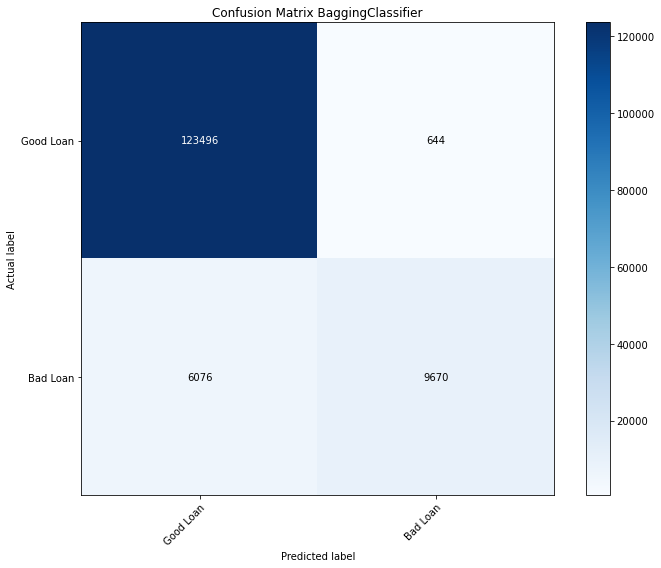

In [43]:
target = ['Good Loan', 'Bad Loan']
y_pred = BaggingClassifier.predict(x_test)

plot_confusion_matrix(y_test, y_pred, target, title = 'Confusion Matrix BaggingClassifier', figsize=(10,8))

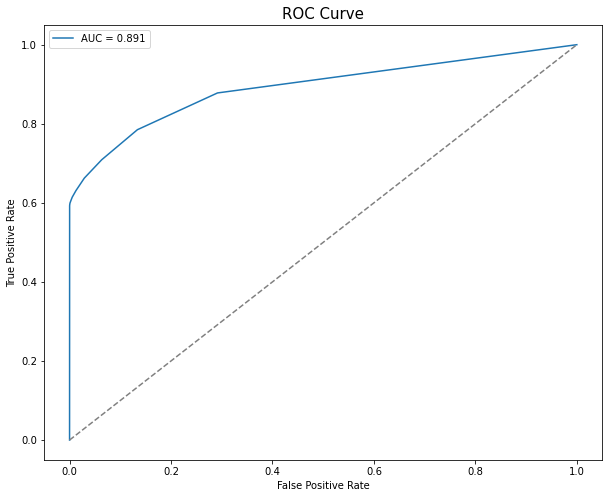

In [44]:
plot_roc_curve(BaggingClassifier, x_test, y_test)

In [45]:
plot_top_features_importance(BaggingClassifier, df_modeling, 'target_status')

Model doesn't have feature_importances_ attribute.


### Stacking Classifier

In [14]:
from sklearn.ensemble import StackingClassifier

# Create the estimators
estimators = [
    ('rf', RandomForestClassifier()),
    ('xgboost', XGBClassifier())
]
meta_model = DecisionTreeClassifier()

StackingClassifier = StackingClassifier(estimators = estimators, final_estimator = meta_model)
StackingClassifier.fit(x_train_smote, y_train_smote)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              in...tion_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=DecisionTreeClassifier())

In [15]:
evaluate_model(StackingClassifier, x_test, y_test, x_train_smote, y_train_smote)

Classification Report StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                            

Confusion matrix, without normalization
[[120823   3468]
 [  6309   9286]]


<AxesSubplot:title={'center':'Confusion Matrix StackingClassifier'}, xlabel='Predicted label', ylabel='Actual label'>

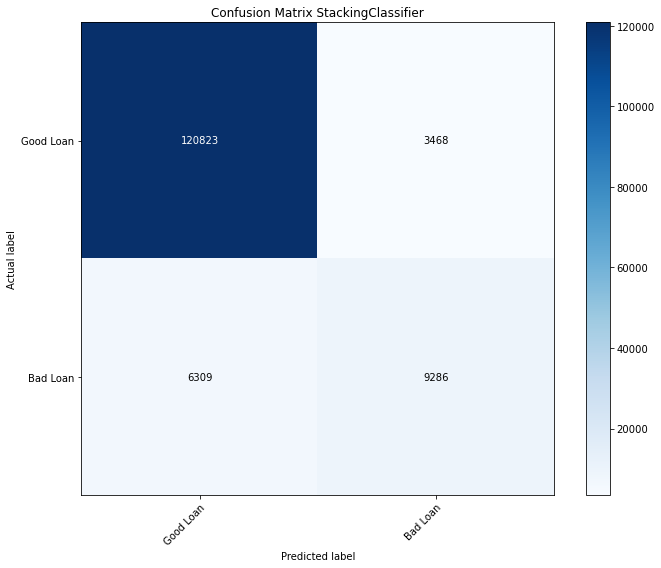

In [16]:
target = ['Good Loan', 'Bad Loan']
y_pred = StackingClassifier.predict(x_test)

plot_confusion_matrix(y_test, y_pred, target, title = 'Confusion Matrix StackingClassifier', figsize=(10,8))

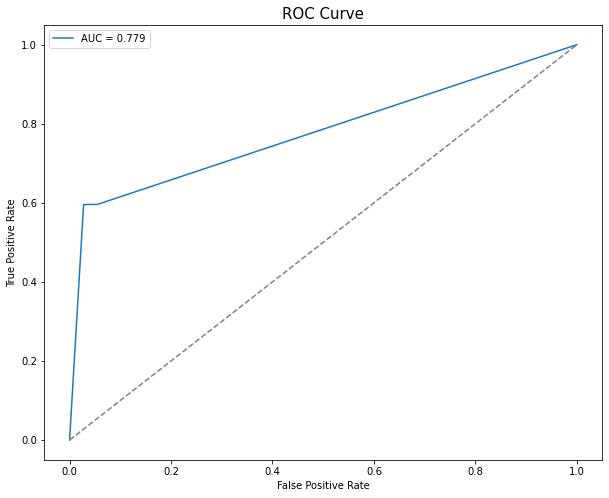

In [17]:
plot_roc_curve(StackingClassifier, x_test, y_test)

## Hyperparameter Tuning Model

### Decision Tree

In [22]:
DecisionTreeHT = DecisionTreeClassifier()

param_grid = {"criterion":['gini','entropy'],
              "max_depth":[3, 5, 7, 10, 15],
              "min_samples_split":[4, 8, 16, 25],
              "min_samples_leaf":[5, 25, 10, 100],
              "max_features":['auto','sqrt'],
              "random_state": [0, 42]}

grid_search = GridSearchCV(DecisionTreeHT, param_grid, cv=5)
grid_search.fit(x_train_smote, y_train_smote)
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4, 'random_state': 0}


In [23]:
DecisionTreeHT = DecisionTreeClassifier(criterion = 'gini', max_depth = 15, 
                                        max_features = 'sqrt', min_samples_leaf = 5, 
                                        min_samples_split = 4, random_state = 0)

DecisionTreeHT.fit(x_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=4, random_state=0)

In [24]:
evaluate_model(DecisionTreeHT, x_test, y_test, x_train_smote, y_train_smote)

Classification Report DecisionTreeClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=4, random_state=0):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    124291
           1       0.93      0.59      0.72     15595

    accuracy                           0.95    139886
   macro avg       0.94      0.79      0.85    139886
weighted avg       0.95      0.95      0.94    139886

AUC Score Train Proba: 0.984097
AUC Score Test proba: 0.898174



Confusion matrix, without normalization
[[123648    643]
 [  6445   9150]]


<AxesSubplot:title={'center':'Confusion Matrix DecisionTree After Hyperparameter Tuning'}, xlabel='Predicted label', ylabel='Actual label'>

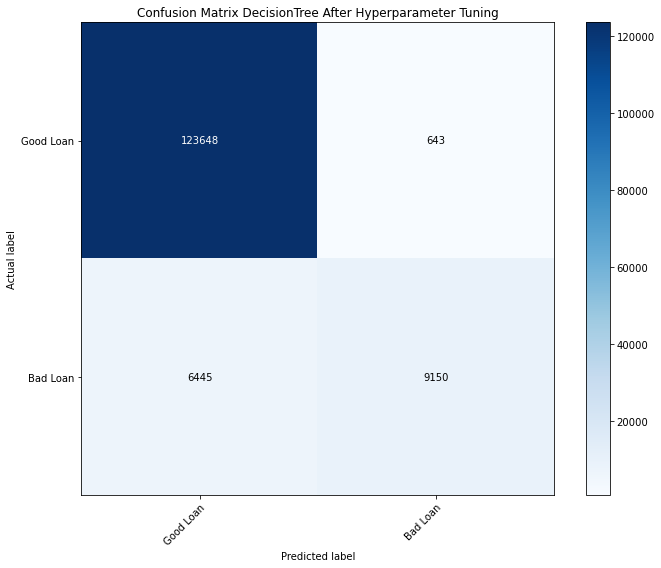

In [25]:
target = ['Good Loan', 'Bad Loan']
y_pred = DecisionTreeHT.predict(x_test)

plot_confusion_matrix(y_test, y_pred, target, title = 'Confusion Matrix DecisionTree After Hyperparameter Tuning', figsize=(10,8))

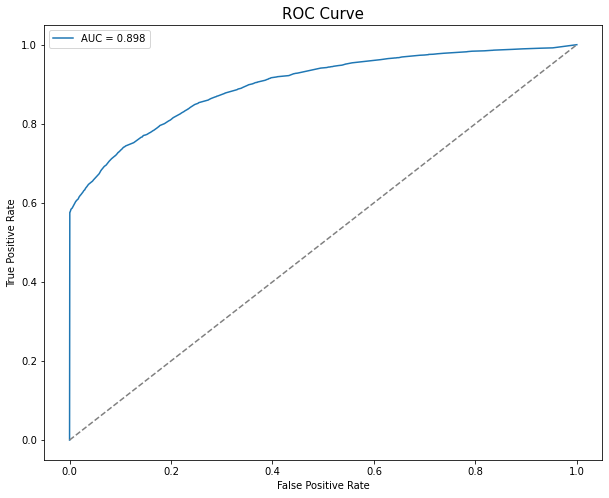

In [26]:
plot_roc_curve(DecisionTreeHT, x_test, y_test)

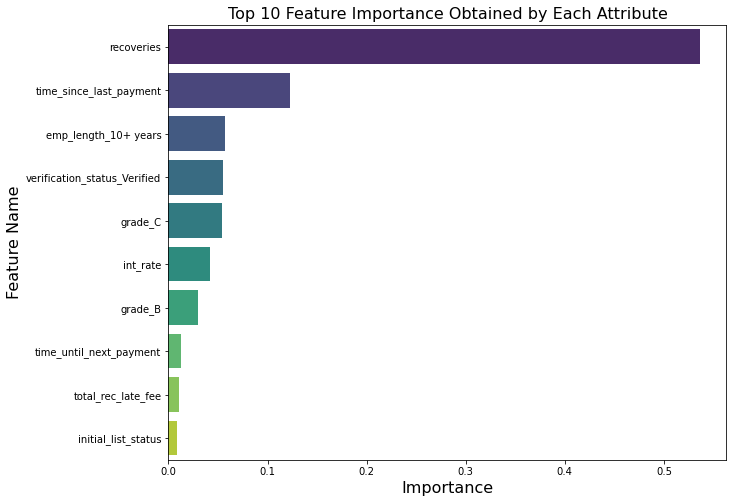

In [27]:
plot_top_features_importance(DecisionTreeHT, df_modeling, 'target_status')

## Discussion and Result

Based on the model evaluation results using various metrics, the performance discussion is as follows:

1. In terms of accuracy, precision, recall, F1-Score, AUC-Proba Train, and AUC-Proba Test, it is evident that two models stand out with the best performance—Random Forest Classifier and XGBoost Classifier. Random Forest achieves accuracy of 95%, precision 97%, recall 80%, F1-Score 86%, AUC-Proba Train 100%, and AUC-Proba Test 92%. On the other hand, XGBoost Classifier attains accuracy of 95%, precision 96%, recall 80%, F1-Score 86%, AUC-Proba Train 99%, and AUC-Proba Test 93%. This analysis indicates that both models, Random Forest Classifier and XGBoost Classifier, exhibit excellent performance in predicting credit risk, showcasing a high ability to classify data accurately.

2. The importance of assessing precision and recall is evident in this evaluation. Random Forest Classifier achieves a precision of 97%, highlighting its efficiency in identifying true positives and minimizing false positives. Simultaneously, a recall of 80% demonstrates the model's ability to detect as many true positives as possible. XGBoost Classifier, despite having a slightly lower precision (96%), maintains a good balance with an 80% recall. With an F1-Score of 86% for both models, it can be concluded that they successfully achieve a balanced trade-off between precision and recall.

3. Additionally, the high AUC-Proba Train and AUC-Proba Test for both models indicate their ability to differentiate effectively between positive and negative categories. Random Forest Classifier achieves an AUC-Proba Test of 92%, while XGBoost Classifier reaches 93%. Overall, these results instill confidence that both Random Forest Classifier and XGBoost Classifier have strong potential for application in credit risk management, providing accurate and consistent predictions on both training and test data.

4. In detailing the confusion matrix evaluation results, RandomForestClassifier achieves 124,039 True Positives (TP), 101 False Positives (FP), 6,282 False Negatives (FN), and 9,464 True Negatives (TN). This indicates the model's capability to predict 124,039 good loans and 9,464 bad loans. Although the model still has the potential for prediction errors, as indicated by lower FP and FN values compared to TP and TN, these results affirm the RandomForestClassifier's proficiency in predicting both good_loan and bad_loan.

5. XGBoostClassifier, with 123,893 TP, 247 FP, 6,141 FN, and 9,605 TN, exhibits a similar pattern to RandomForestClassifier. The percentage of correct predictions is more dominant than prediction errors (FP and FN), confirming the model's reliability in predicting the categories of good_loan and bad_loan.

6. The results of the feature importances plot from RandomForestClassifier and XGBoostClassifier highlight the significance of features such as recoveries, time_since_last_payment, initial_list_status, time_until_next_payment, inq_last_6mths, and grade. Analysis of these features can serve as a foundation for credit risk assessment. Focusing on these features is expected to provide more accurate recommendations regarding the most influential factors in determining credit risk.